In [1]:
import numpy as np

# Expected Value of Cost function in population setting
## Projecting $p$ entries as sigmoids 
We have 

$$C(A, P) = \text{Tr}\left((B^* - B)\Sigma_X(B^* - B)\right),$$

where $$B = P^{-1}AP.$$

Here, $A$ is lower triangular and $P$ is a doubly stochastic matrix, namely

\begin{align*}
0 \leq &p_{ij} &\forall\ i,j = 1, \cdots, n\\
\sum_{j = 1}^n &p_{ij} = 1&\forall\ i = 1, \cdots, n\\
\sum_{i=1}^n &p_{ij} = 1 &\forall\ j = 1, \cdots, n\\
\end{align*}

In [3]:
# actual solution
n = 3
As = np.tril(np.random.rand(n, n))
Ps = np.identity(n)
Sigma = np.identity(n)
rho = 0.0

print(f"A*:\n{np.round(As, 2)}\n\nP*:\n{Ps}")

A*:
[[0.67 0.   0.  ]
 [0.51 0.4  0.  ]
 [0.78 0.94 0.72]]

P*:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
def expected_cost(A, P_sigma, As = As, Ps = Ps):
    # base on the distribution of X, no actual data needed.
    # we need the covariance of X_t - X_{t-1}.
    # Then, the expected cost is the trace of this covariance
    P = sigmoid(P_sigma)
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix)

A = np.random.rand(n, n)
P = np.zeros((n, n)) + np.random.rand(n, n) / n
print(f"Expected cost: {expected_cost(A, P)}.")

Expected cost: 15308.92150417755.


## Dealing with the constraints
### Non-negativity constraints
To deal with the constraints that $p$ must be non-negative, we project the entries by applying the sigmoid function of each entry. Note that the range of the sigmoid is $(0, 1)$, which is also what we require for our entries $p$ (we did not explicitly constrain $p$ to be smaller than 1, but the equality constraints combined with the non-negativity constraints make sure that is the case.

$$\mathcal{L}(A, P, \mathbf{\lambda}) = C(A, \sigma(P))$$


## Dealing with equality constraints
To deal with the $2n$ equality constraints, we use $\textit{lagrange multipliers}$ $\lambda_{row, i}$, $i = 1, \cdots, n$ and $\lambda_{col, j}$, $j = 1, \cdots, n$. The dual function now becomes 

$$\mathcal{L}(A, P, \mathbf{\lambda}) = C(A, \sigma(P)) - \sum_{i=1}^n \lambda_{row, i} \left(\sum_{j = 1}^n \sigma(p_{ij}) - 1\right) - \sum_{j = 1}^n \lambda_{col, j} \left(\sum_{i = 1}^n \sigma(p_{ij}) - 1\right).$$

In [6]:
def expected_cost_lagrange(A, P_sigma, As = As, Ps = Ps):
    
    P = sigmoid(P_sigma)
    exp_cost = expected_cost(A, P_sigma)
    lambda_cost = 0
    
    for i in range(n):
        lambda_cost += lambdas[0][i] * (sum(P[:, i]) - 1)
        lambda_cost += lambdas[1][i] * (sum(P[i]) - 1)
        
    return exp_cost - lambda_cost

# lambdas = np.zeros((2, n))
# P = np.ones((n, n)) / n + np.random.rand(n, n) / n
# print(f"Expected lagrange cost: {expected_cost(np.random.rand(n,n), Ps)}.")

## Optimizing $\mathcal{L}(A, P_\sigma, \mathbf{\lambda})$
let $$q(\mathbf{\lambda}) = \inf_{A, P} \mathcal{L}(A, P, \mathbf{\lambda}).$$
Then the $\textit{dual problem}$ is $$\max_{\mathbf{\lambda}} q(\mathbf{\lambda}).$$

## Deriving $q(\mathbf{\lambda})$
To minimize $\mathcal{L}(A, P_\sigma, \mathbf{\lambda})$, we will use gradient descent.

The partial derivative with respect to entries in $A$ is simple, 

$$\frac{\partial\mathcal{L}(A, P, \mathbf{\lambda})}{\partial a_{ij}} = \frac{\partial C(A, \sigma(P))}{\partial a_{ij}}$$

Now, the partial derivative with respect to the entries in $p$ is more involved as it occurs also in exactly two equality constraints, namely in $\lambda_{row, i}$ and in $\lambda{col, j}$.

$$\frac{\partial\mathcal{L}(A, P, \mathbf{\lambda})}{\partial \sigma(p_{ij})} = \left(\frac{\partial C(A, \sigma(P))}{\partial \sigma(p_{ij})} - \lambda_{row, i} - \lambda_{col, j}\right).$$

Now, applying the chain rule, we get that

\begin{align*}\frac{\partial\mathcal{L}(A, P, \mathbf{\lambda})}{\partial p_{ij}} &= \frac{\partial\mathcal{L}(A, P, \mathbf{\lambda})}{\partial \sigma(p_{ij})}\frac{\partial \sigma(p_{ij})}{p_{ij}}\\ &= \frac{\partial\mathcal{L}(A, P, \mathbf{\lambda})}{\partial \sigma(p_{ij})} \sigma(p_{ij})(1 - \sigma(p_{ij})\end{align*}
Now, as $C(A, P)$ is unfortunately yet inevitably non-convex, we cannot expect to find the infimum $q(\mathbf{\lambda})$. However, let us consider a local minimum $\tilde{q}(\mathbf{\lambda})$, which we will find by gradient descent. 

For a sufficiently small step size, we will do this gradient descent until we have found a stationary point:
$$(A_{t + 1}, P_{t + 1}) = (A_t, P_t) - \eta\ \nabla \mathcal{L}(A_t, P_t, \mathbf{\lambda})$$
Note that this is an $\textit{unconstrained}$ optimization problem now, which should make things more easy. 

Suppose that after a number of iterations, we have found this local minimum with parameters $\tilde{A}$, $\tilde{P}$. Then, we have that $$\tilde{q}(\mathbf{\lambda}) = \mathcal{L}(\tilde{A}, \tilde{P}, \mathbf{\lambda}).$$

In [7]:
# get gradient of our outcome
def grad_a(A, P_sigma, i, j, As = As, Ps = Ps):
    P = sigmoid(P_sigma)
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    return -2 * np.trace(np.matmul(covariance_X, np.matmul((Bs - B).transpose(), np.matmul(P_inv, np.matmul(J, P)))))

def grad_p(A, P_sigma, i, j, As = As, Ps = Ps):
    P = sigmoid(P_sigma)
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    B_grad = np.matmul(P_inv, np.matmul(A, J))
    B_grad -= np.matmul(P_inv, np.matmul(J, np.matmul(P_inv, np.matmul(A, P))))
    
    grad_p_sigma = -2 * np.trace(np.matmul(covariance_X, np.matmul((Bs - B).transpose(), B_grad))) - lambdas[0][j] - lambdas[1][i] - rho * np.trace(np.matmul(P.transpose(), J))
    return grad_p_sigma * sigmoid(P[i][j]) * (1 - sigmoid(P[i][j]))

def get_gradient(A, P):
    gradient = np.zeros(int(n * (n + 1) / 2 + n ** 2))
    index = 0
    
    for i in range(n):
        for j in range(i + 1):
            gradient[index] = grad_a(A, P, i, j)
            index += 1
            
    for i in range(n):
        for j in range(n):
            gradient[index] = grad_p(A, P, i, j)
            index += 1
            
    return gradient

In [156]:
J = np.zeros((n, n))
J[2][1] = 1
print(P)
print(- rho * np.trace(np.matmul(P.transpose(), J)))

[[ 0.34410832  0.20425962  0.46652542]
 [ 0.74509498 -0.0435191   0.33569267]
 [-0.05700059  0.89697634  0.18644497]]
-0.08969763394224575


## Deriving the dual problem
Now that we have $\tilde{q}(\mathbf{\lambda})$, the solution to the dual problem is
$$\max_{\lambda} \tilde{q}(\mathbf{\lambda}),$$
which is again an unconstrained optimization problem, which we can also optimize by maximizing $\lambda$'s.

## Final Algorithm
To solve this problem, we simply iterate the following:
- While $\nabla \mathcal{L}(A_t, P_t, \mathbf{\lambda}) \geq 0$:
    - $(A_{t + 1}, P_{t + 1}) = (A_t, P_t) - \eta\ \nabla \mathcal{L}(A_t, P_t, \mathbf{\lambda})$
    - $\lambda_{ineq, i, j} = max(0, p_{ij})\ \forall i, j = 1, \cdots, n$
    - $\lambda_{row, i} = 1 - \sum_{j=1}^n p_{ij} \ \forall i = 1, \cdots, n$
    - $\lambda_{col, j} = 1 - \sum_{i=1}^n p_{ij} \ \forall j = 1, \cdots, n$
    
We will end up in a local optimum of $C(A, P)$ while also fullfilling the constraints.

In [171]:
# Initial values
A = As.copy()
P = Ps.copy()
lambdas = np.zeros((2, n))

In [172]:
# step size
eta = 1e-4

In [147]:
rho = 0.00

In [205]:
# the algorithm
grad = get_gradient(A, P)

previous_cost = 1e10

# while gradient is larger than zero (or a value close)
while np.sum(np.abs(grad)) > 0.00001:
    
    # get gradient
    A_grad = np.zeros((n , n))
    A_grad[np.tril_indices(n)] = grad[:int(n * (n + 1) / 2)]
    P_grad = grad[int(n * (n + 1) / 2):].reshape((n , n))

    # update A and B according to gradient
    A -= eta * A_grad 
    P -= eta * P_grad
    
    new_cost = expected_cost_lagrange(A, P)
    if new_cost > previous_cost:
        print("Revert gradient", eta)
        A += eta * A_grad
        P += eta * P_grad
        
        eta /= 2
        
    else: # recompute gradient
        eta *= 1.1
        
        previous_cost = new_cost
        
        grad = get_gradient(A, P)
    
        print("Gradient:", np.sum(np.abs(grad)))
        print(expected_cost_lagrange(A, P))    
    
        # update equality constraints
        for row_or_col in range(2):
            for i in range(n):
                lagrange[row_or_col][i] = grad_lambda(A, sigmoid(P), i, row_or_col)

        # update equality constraints
        lambdas = lagrange 

Gradient: 0.0012683902221178706
3.000030426143272
Gradient: 0.0017042880985531433
3.000030425860256
Revert gradient 0.02402322176576475
Gradient: 0.0012830726883057643
3.0000304249902237
Gradient: 0.0011782884789104916
3.0000304244377562
Gradient: 0.0010908765684530326
3.0000304239260904
Gradient: 0.0011626623885585218
3.000030423397494
Gradient: 0.0012191745456626318
3.000030422868781
Gradient: 0.0014799910023934647
3.0000304224217644
Revert gradient 0.021279301387289996
Gradient: 0.0010356285951935126
3.0000304217406017
Gradient: 0.0009586066996565088
3.0000304213032187
Gradient: 0.0009131614166074653
3.000030420861236
Gradient: 0.000916641213945212
3.00003042038021
Gradient: 0.0009059138741974242
3.0000304198545478
Gradient: 0.0009304191062946548
3.0000304192776586
Gradient: 0.0009434986018170387
3.00003041864934
Gradient: 0.0010512362709977246
3.0000304179769284
Gradient: 0.001229682693654776
3.0000304173329413
Gradient: 0.0018247361864728077
3.0000304171790373
Revert gradient 0.02

Gradient: 0.0010825756854206442
3.000030340005902
Gradient: 0.0014532512676251482
3.0000303394046597
Revert gradient 0.029844722216412357
Gradient: 0.001436059640723202
3.0000303388450984
Gradient: 0.0014968583016729082
3.0000303383877442
Gradient: 0.0017561686766939396
3.0000303381136337
Revert gradient 0.019861662635022426
Gradient: 0.001050045091097081
3.0000303370871815
Gradient: 0.0009444204762253343
3.000030336664199
Gradient: 0.0008978420986334465
3.0000303362534004
Gradient: 0.0008942715030657592
3.0000303358065668
Gradient: 0.0008852438583099744
3.0000303353173816
Gradient: 0.0008928181160611946
3.0000303347793706
Gradient: 0.0008937149813805819
3.000030334188886
Gradient: 0.0009233151063561694
3.0000303335411767
Gradient: 0.0009548043423975646
3.0000303328387252
Gradient: 0.0011296838011206848
3.0000303321119963
Gradient: 0.0015226276622524663
3.000030331611337
Revert gradient 0.028333820737551647
Gradient: 0.0014263884794659925
3.000030330990737
Gradient: 0.00141544363930140

Gradient: 0.0010790764035734578
3.000030256445549
Gradient: 0.0009128804035407547
3.0000302560490475
Gradient: 0.0008926642355120716
3.000030255656919
Gradient: 0.0008788432495260133
3.000030255232074
Gradient: 0.0008764873056302329
3.00003025476503
Gradient: 0.0008777406895800567
3.0000302542519433
Gradient: 0.0008795993715413219
3.0000302536874806
Gradient: 0.0008829679692715686
3.0000302530673264
Gradient: 0.0009070390995463164
3.000030252386421
Gradient: 0.0009343352672372831
3.0000302516451787
Gradient: 0.0010974124429774248
3.0000302508702603
Gradient: 0.0014971994464011249
3.0000302503147416
Revert gradient 0.029856387704880354
Gradient: 0.0014747054690918502
3.0000302497519864
Gradient: 0.00154585448402018
3.0000302493105404
Gradient: 0.001817663960298308
3.0000302490867865
Revert gradient 0.01986942601759788
Gradient: 0.0010631990678980198
3.0000302479656735
Gradient: 0.0009485560742759292
3.0000302475364586
Gradient: 0.0008984755640665961
3.000030247126332
Gradient: 0.0008948

Gradient: 0.0008903797266314052
3.0000301741254956
Gradient: 0.0008948474209364618
3.0000301736350625
Gradient: 0.000890202257295954
3.000030173097297
Gradient: 0.0009112079628001912
3.000030172506558
Gradient: 0.0009244760207237837
3.000030171861652
Gradient: 0.0010221561150071164
3.000030171168588
Gradient: 0.0011980167214738367
3.0000301704965113
Gradient: 0.0018118046445100395
3.000030170328144
Revert gradient 0.028600702224735645
Gradient: 0.0016679992779118416
3.0000301696199974
Gradient: 0.0017080015341528407
3.000030169146094
Gradient: 0.001954226471694629
3.0000301689541526
Revert gradient 0.019033767330561575
Gradient: 0.0010825471642540326
3.000030167621335
Gradient: 0.000912365638410445
3.0000301672243923
Gradient: 0.0008915858511389962
3.000030166833621
Gradient: 0.0008770499059462798
3.0000301664105327
Gradient: 0.0008750665235631278
3.000030165945443
Gradient: 0.0008759293930800223
3.0000301654345316
Gradient: 0.000878298775525349
3.0000301648724625
Gradient: 0.000881687

Gradient: 0.0010122251353989144
3.000030090422579
Gradient: 0.0009975852635539957
3.000030089948181
Gradient: 0.0009665527630065818
3.000030089446593
Gradient: 0.001016265957887197
3.0000300889034888
Gradient: 0.0010445289756572656
3.0000300883283963
Gradient: 0.0012523018328033197
3.000030087760538
Gradient: 0.0016201818490159197
3.0000300874335326
Revert gradient 0.0242684615684257
Gradient: 0.0012852346782346157
3.000030086640358
Gradient: 0.0011165335474379412
3.0000300861139566
Gradient: 0.0011297174735150806
3.0000300856062903
Gradient: 0.0011153813547847798
3.0000300850891084
Gradient: 0.0012653599691311384
3.000030084569126
Gradient: 0.0014860719434568613
3.0000300841586234
Revert gradient 0.021496530022310913
Gradient: 0.0010914153298033356
3.000030083446404
Gradient: 0.0009468542531487014
3.0000300830107927
Gradient: 0.0009297580400004059
3.000030082568177
Gradient: 0.0009054154160382159
3.0000300820916284
Gradient: 0.0009220548239073258
3.0000300815692786
Gradient: 0.0009228

Gradient: 0.0013021592733697149
3.000030008063438
Gradient: 0.0018089597665449334
3.000030007924029
Revert gradient 0.025572569414460015
Gradient: 0.001465159292462615
3.0000300070205745
Gradient: 0.0013229005749894936
3.0000300064455336
Gradient: 0.0013589265219378195
3.0000300059357454
Gradient: 0.0014514649812636872
3.0000300054947138
Gradient: 0.0017568330655173576
3.0000300052642612
Revert gradient 0.020592439383841008
Gradient: 0.0010884628755310065
3.000030004243705
Gradient: 0.0009671820240329793
3.0000300037978462
Gradient: 0.0009078274443886115
3.000030003375297
Gradient: 0.0009070395466266465
3.0000300029186375
Gradient: 0.0008938671473906828
3.0000300024203645
Gradient: 0.0009127407287447787
3.0000300018731543
Gradient: 0.0009190619342273153
3.0000300012754404
Gradient: 0.0009936252784779125
3.0000300006280973
Gradient: 0.0011009382831255604
3.0000299999662126
Gradient: 0.0015262297950151109
3.000029999503803
Revert gradient 0.02670574219345197
Gradient: 0.00130681321492886

Gradient: 0.001705500392114445
3.000029926112477
Revert gradient 0.02169900980626909
Gradient: 0.0011377605363667865
3.0000299251811793
Gradient: 0.0010167419892643688
3.0000299247044415
Gradient: 0.0009403052571317372
3.000029924256295
Gradient: 0.0009438292364683372
3.000029923775844
Gradient: 0.0009327521219041452
3.000029923255395
Gradient: 0.0009838622375248523
3.000029922688704
Gradient: 0.0010268204987105983
3.0000299220871582
Gradient: 0.0012553373848777532
3.0000299215024593
Gradient: 0.0017067494586316804
3.000029921255665
Revert gradient 0.0255825650348393
Gradient: 0.0014042683080412919
3.000029920437484
Gradient: 0.0012694429577550796
3.0000299198843856
Gradient: 0.0013087055963808994
3.0000299193765043
Gradient: 0.001387523312941836
3.0000299189177695
Gradient: 0.0016723797477589616
3.0000299186246377
Revert gradient 0.020600488407129528
Gradient: 0.0010575743115306606
3.0000299177195076
Gradient: 0.0009530890087111855
3.0000299172867537
Gradient: 0.0009008446102246069
3.

Gradient: 0.0012983067943735666
3.0000298433145254
Gradient: 0.0017913334448582986
3.000029843178557
Revert gradient 0.02450662591666345
Gradient: 0.0013660647244438738
3.0000298422355667
Gradient: 0.001249265357273935
3.000029841662964
Gradient: 0.0011776873451432828
3.0000298411567066
Gradient: 0.0012655202338367022
3.0000298406553245
Gradient: 0.0013896825897921755
3.000029840206008
Gradient: 0.001754177596389314
3.000029840008878
Revert gradient 0.021707491357775117
Gradient: 0.0011590847106508284
3.000029839013342
Gradient: 0.0010270093400936624
3.0000298385284703
Gradient: 0.0009453748853918742
3.0000298380801076
Gradient: 0.0009477037679046441
3.0000298376010814
Gradient: 0.000937573761479546
3.000029837083106
Gradient: 0.000992857606295973
3.0000298365199987
Gradient: 0.0010379100049149627
3.0000298359252286
Gradient: 0.0012823840462130897
3.000029835358626
Gradient: 0.0017708015441199312
3.0000298351860963
Revert gradient 0.02559256456223416
Gradient: 0.001442244604015922
3.00

Gradient: 0.0008655502627577905
3.0000297603536614
Gradient: 0.000859789971498948
3.0000297598566745
Gradient: 0.0008659661964833052
3.0000297593102934
Gradient: 0.0008670555693608021
3.0000297587092772
Gradient: 0.0008733429043512053
3.0000297580490396
Gradient: 0.0009062941518933503
3.000029757325291
Gradient: 0.0009601347856301265
3.000029756545609
Gradient: 0.0012413466948678223
3.0000297557986957
Revert gradient 0.02966460791542715
Gradient: 0.0011704705419356746
3.0000297552836894
Gradient: 0.0012582124729606642
3.0000297547838883
Gradient: 0.0013807407175564508
3.0000297543341277
Gradient: 0.0017422951923520985
3.000029754130389
Revert gradient 0.021715976224488454
Gradient: 0.0011537810816541548
3.0000297531504816
Gradient: 0.0010236005953709133
3.000029752668994
Gradient: 0.0009428307627883023
3.0000297522227632
Gradient: 0.0009453116208777102
3.0000297517457852
Gradient: 0.0009352925274701009
3.000029751229972
Gradient: 0.0009904059508123444
3.0000297506691727
Gradient: 0.001

Gradient: 0.0011951675958350935
3.000029678001216
Gradient: 0.0013432250536767648
3.0000296775325523
Gradient: 0.001765254513072649
3.000029677370894
Revert gradient 0.022882921846434902
Gradient: 0.001240971462621769
3.000029676393709
Gradient: 0.0011064611578946461
3.000029675869088
Gradient: 0.0010097817131898635
3.0000296753941242
Gradient: 0.0010422582116839877
3.0000296748957593
Gradient: 0.0010382232514924165
3.0000296743706927
Gradient: 0.0011907701944696431
3.0000296738312593
Gradient: 0.0014083075471450278
3.00002967338349
Revert gradient 0.022296170550055647
Gradient: 0.001089636645148152
3.0000296727439233
Gradient: 0.0009539701713604817
3.000029672304554
Gradient: 0.000938808253588471
3.000029671854751
Gradient: 0.0009161560342359192
3.0000296713716788
Gradient: 0.0009425970113007736
3.0000296708437157
Gradient: 0.0009599030076056385
3.0000296702725264
Gradient: 0.00108207425613941
3.000029669667844
Gradient: 0.0012728551210224425
3.000029669111626
Gradient: 0.001852446078

Gradient: 0.001230918946554807
3.0000295958193983
Gradient: 0.0015052801502345727
3.000029595427625
Revert gradient 0.021358449017924067
Gradient: 0.001034914316483273
3.000029594721636
Gradient: 0.0009516354158282108
3.000029594293073
Gradient: 0.0009018844621786628
3.0000295938667607
Gradient: 0.0009055163936637928
3.0000295934039025
Gradient: 0.0008938407728062126
3.000029592898953
Gradient: 0.0009222161415415454
3.000029592345306
Gradient: 0.0009420938779141497
3.0000295917444975
Gradient: 0.0010693445276940981
3.0000295911089454
Gradient: 0.0012920654722781547
3.0000295905396936
Revert gradient 0.025181052772577657
Gradient: 0.0011363042806462036
3.0000295899853167
Gradient: 0.0010281581543273425
3.0000295895064535
Gradient: 0.0010657542586938957
3.000029589009627
Gradient: 0.0010651463982945264
3.000029588491232
Gradient: 0.0012311670985690859
3.0000295879684624
Gradient: 0.0014812167046302398
3.0000295875731684
Revert gradient 0.02230488551542023
Gradient: 0.0011195203424143496


3.000029505872303
Gradient: 0.0010321265074831388
3.0000295053783073
Gradient: 0.00102890607366491
3.000029504856863
Gradient: 0.0011775522527467804
3.0000295043194485
Gradient: 0.0013891444662539971
3.0000295038673306
Revert gradient 0.02231360388722726
Gradient: 0.0010802573122891603
3.0000295032440962
Gradient: 0.0009480570632808358
3.0000295028099333
Gradient: 0.0009336448071446626
3.0000295023641734
Gradient: 0.0009114124854113432
3.0000295018851566
Gradient: 0.0009377199422504406
3.000029501361501
Gradient: 0.0009548859249884776
3.000029500794876
Gradient: 0.0010759357500432548
3.0000295001947666
Gradient: 0.0012653324846615018
3.0000294996419523
Gradient: 0.0018414737984312794
3.000029499587762
Revert gradient 0.026307155381888096
Gradient: 0.0015274128902053124
3.0000294987002296
Gradient: 0.0014539866777052654
3.0000294981246505
Gradient: 0.0014806838893942434
3.000029497668069
Gradient: 0.0016892084627745853
3.000029497360374
Revert gradient 0.019258153097311187
Gradient: 0.0

Gradient: 0.0009528492400475296
3.0000294267192977
Gradient: 0.0009005458928967996
3.000029426295856
Gradient: 0.0009041754332126777
3.000029425836562
Gradient: 0.000892449036852862
3.000029425335799
Gradient: 0.0009217719220009828
3.0000294247869346
Gradient: 0.0009437481758191929
3.000029424192072
Gradient: 0.0010772998658645958
3.0000294235654232
Gradient: 0.0013139640122269826
3.0000294230180673
Revert gradient 0.02520074179416703
Gradient: 0.0011484763836182672
3.000029422454934
Gradient: 0.001035022959235092
3.0000294219768926
Gradient: 0.0010756440791004293
3.000029421483956
Gradient: 0.0010795806275354714
3.000029420972707
Gradient: 0.001251088126120587
3.0000294204634583
Gradient: 0.001520977456500156
3.000029420104296
Revert gradient 0.022322325666808175
Gradient: 0.0011347558759589376
3.0000294193682295
Gradient: 0.0009729271949429817
3.000029418917412
Gradient: 0.0009539497952936321
3.0000294184686926
Gradient: 0.0009270812536696415
3.000029417991033
Gradient: 0.00096090076

Gradient: 0.0008739559116627711
3.00002934651936
Gradient: 0.0008748463688634754
3.000029345956636
Gradient: 0.0009077027528682859
3.000029345339833
Gradient: 0.0009460057698630064
3.000029344673479
Gradient: 0.001141524565372984
3.0000293439969825
Gradient: 0.0015951689969996923
3.000029343624348
Revert gradient 0.02846144397767176
Gradient: 0.001482020705612032
3.000029343004268
Gradient: 0.001489141931683789
3.0000293425374283
Gradient: 0.0016732948734704477
3.0000293422114317
Revert gradient 0.01894109096714056
Gradient: 0.000975279546535708
3.0000293412881893
Gradient: 0.0008921638484623384
3.000029340921864
Gradient: 0.000860867503297804
3.000029340553559
Gradient: 0.0008559209545808604
3.000029340150268
Gradient: 0.0008567558954551161
3.000029339707709
Gradient: 0.0008524215131109553
3.0000293392207578
Gradient: 0.0008572656091720478
3.000029338685477
Gradient: 0.0008608972748374554
3.0000293380966956
Gradient: 0.0008677624623506264
3.000029337450171
Gradient: 0.0009064843719776

Gradient: 0.001389854436156191
3.0000292633609114
Revert gradient 0.02656532693915189
Gradient: 0.0012463447379265108
3.0000292627748433
Gradient: 0.001163428740370708
3.000029262281105
Gradient: 0.0012376281486460336
3.000029261793581
Gradient: 0.0013411593512484925
3.0000292613466697
Gradient: 0.001666112575895821
3.000029261094918
Revert gradient 0.021391862344386763
Gradient: 0.0010970512546254517
3.000029260204785
Gradient: 0.0009812914023122695
3.0000292597563325
Gradient: 0.0009115479361568719
3.0000292593318085
Gradient: 0.0009145725334052162
3.000029258874916
Gradient: 0.0009019542876402182
3.000029258378616
Gradient: 0.0009364234725014347
3.0000292578359415
Gradient: 0.0009689424786551134
3.000029257252117
Gradient: 0.0011363237975380869
3.0000292566522826
Gradient: 0.0014444311949305035
3.0000292562075312
Revert gradient 0.025220446210568324
Gradient: 0.0012254697503632141
3.0000292555714374
Gradient: 0.0010996733669084184
3.0000292550790633
Gradient: 0.001136882862308804
3.

Gradient: 0.001260754072523783
3.0000291825550973
Gradient: 0.001712691783863321
3.000029182368327
Revert gradient 0.024159736910353686
Gradient: 0.0012919243007804679
3.0000291814967657
Gradient: 0.0011796931644155006
3.000029180961629
Gradient: 0.001099644881256999
3.0000291804783235
Gradient: 0.0011729472051907163
3.000029179986426
Gradient: 0.0012523703697767546
3.0000291795114986
Gradient: 0.0015405170847549228
3.000029179164507
Revert gradient 0.02140022384032155
Gradient: 0.0010442097459820792
3.0000291784212467
Gradient: 0.000954450682273279
3.000029177993568
Gradient: 0.0008984824983115621
3.0000291775743704
Gradient: 0.0009021304038188825
3.00002917712035
Gradient: 0.0008903469589978349
3.0000291766257865
Gradient: 0.0009210870935146433
3.000029176084021
Gradient: 0.0009461998298252056
3.0000291754980393
Gradient: 0.0010891784468678206
3.0000291748848893
Gradient: 0.0013467642989910486
3.0000291743715413
Revert gradient 0.025230304195584696
Gradient: 0.001166861311577281
3.00

Gradient: 0.0013002990387717913
3.0000291072751804
Gradient: 0.0012339715650025325
3.000029106750569
Gradient: 0.0011998788139383925
3.0000291062689692
Gradient: 0.0013237149572223686
3.0000291058058903
Gradient: 0.0015343280458665585
3.0000291054656523
Revert gradient 0.020500183600565883
Gradient: 0.0010478908685343858
3.0000291047030214
Gradient: 0.0009041383576509471
3.000029104308872
Gradient: 0.0008869262904633779
3.0000291039096347
Gradient: 0.0008667061899380954
3.0000291034784983
Gradient: 0.0008730647138056848
3.000029103004924
Gradient: 0.0008694135074380894
3.00002910248577
Gradient: 0.0008947522041569005
3.000029101915849
Gradient: 0.0009146076855991577
3.000029101295787
Gradient: 0.001041420940478706
3.000029100638801
Gradient: 0.0012887681545883302
3.00002910006059
Revert gradient 0.026586098322316738
Gradient: 0.0011772896583362251
3.0000290995211314
Gradient: 0.0010978427615947917
3.000029099039974
Gradient: 0.0011712502271983933
3.0000290985502716
Gradient: 0.00125129

Gradient: 0.0015338636024831245
3.000029031331054
Revert gradient 0.02160179649857604
Gradient: 0.0011002074322707003
3.0000290305769486
Gradient: 0.0009403102657954672
3.000029030151618
Gradient: 0.0009181326779007677
3.0000290297279575
Gradient: 0.0008921929152138785
3.0000290292747636
Gradient: 0.0009111745718539545
3.0000290287787523
Gradient: 0.0009157263126719008
3.0000290282391564
Gradient: 0.0009967970691536275
3.000029027656645
Gradient: 0.0011017742150951505
3.0000290270661796
Gradient: 0.0014927190703799885
3.0000290266525274
Revert gradient 0.025467953087634648
Gradient: 0.0012200485553254142
3.0000290260093774
Gradient: 0.0011723851973177272
3.0000290255077915
Gradient: 0.0011343585228792842
3.000029025027728
Gradient: 0.0012505467531466646
3.0000290245486276
Gradient: 0.0014228352123159891
3.000029024148809
Gradient: 0.0018729780379285977
3.0000290241426537
Revert gradient 0.022559016219941577
Gradient: 0.0012694456733528066
3.0000290230036897
Gradient: 0.0011057655609414

Gradient: 0.00164628545246503
3.0000289499549386
Revert gradient 0.021610240052049742
Gradient: 0.001140482771031014
3.0000289490838887
Gradient: 0.0009568658787037727
3.000028948644115
Gradient: 0.0009284620539085781
3.000028948218331
Gradient: 0.0008999319817539479
3.000028947766252
Gradient: 0.0009206928717688464
3.000028947272471
Gradient: 0.00092930529547048
3.000028946736972
Gradient: 0.0010240882934390908
3.0000289461626615
Gradient: 0.0011545818205764516
3.0000289455967795
Gradient: 0.0015933174276902267
3.000028945285374
Revert gradient 0.025477907816343227
Gradient: 0.0012912163192922168
3.0000289445697113
Gradient: 0.001226793873823783
3.000028944051029
Gradient: 0.0011937106431416408
3.0000289435739047
Gradient: 0.0013175835382809788
3.000028943114831
Gradient: 0.001528338907348029
3.0000289427781492
Revert gradient 0.020516212658649478
Gradient: 0.0010445645399404977
3.0000289420218857
Gradient: 0.0009008819759558097
3.000028941630696
Gradient: 0.0008837209785670781
3.0000

Gradient: 0.0016808193206115812
3.000028868363102
Revert gradient 0.026158611156112822
Gradient: 0.0014127434603715665
3.0000288676014457
Gradient: 0.001305943964656884
3.0000288670788042
Gradient: 0.0013646314107280638
3.000028866613024
Gradient: 0.0015016946383981046
3.000028866243167
Gradient: 0.0018688862955063361
3.000028866192903
Revert gradient 0.021064352426515644
Gradient: 0.0011544666160260213
3.00002886500141
Gradient: 0.0009959773331995262
3.0000288645348463
Gradient: 0.0009114266962398877
3.000028864120331
Gradient: 0.0009099648123923968
3.0000288636783257
Gradient: 0.0008948958457787548
3.000028863199514
Gradient: 0.000927140541612829
3.0000288626759364
Gradient: 0.0009557567054208176
3.0000288621119897
Gradient: 0.0011095548229816139
3.00002886152768
Gradient: 0.0013825502128049572
3.0000288610632793
Revert gradient 0.024834320583256422
Gradient: 0.0011697369018245968
3.0000288604656324
Gradient: 0.0010407618401320207
3.000028859995497
Gradient: 0.001072538473815337
3.00

Gradient: 0.0016896713239630701
3.0000287885150514
Revert gradient 0.019661033692138077
Gradient: 0.0010025717315236297
3.000028787567039
Gradient: 0.0009028126743452169
3.0000287871833455
Gradient: 0.0008602211631670119
3.0000287868097106
Gradient: 0.0008564767164646089
3.0000287864025474
Gradient: 0.0008484308447011661
3.0000287859566903
Gradient: 0.0008542600420361766
3.000028785466175
Gradient: 0.0008547327956178065
3.000028784927633
Gradient: 0.0008779276629323952
3.0000287843362217
Gradient: 0.0008990519541047404
3.0000287836920374
Gradient: 0.0010316771394859947
3.0000287830107144
Gradient: 0.00132007144221415
3.0000287824375844
Revert gradient 0.028047611843215397
Gradient: 0.0012487513319389579
3.0000287819065674
Gradient: 0.0012189743331993273
3.0000287814343674
Gradient: 0.001346825718477802
3.000028780989391
Gradient: 0.0015785617768101171
3.0000287806905455
Revert gradient 0.020532254249825837
Gradient: 0.00105817196767187
3.000028779880941
Gradient: 0.0009033642184116871


Gradient: 0.0010245368173867034
3.0000287069261447
Gradient: 0.0012971626329438479
3.000028706411586
Revert gradient 0.023799149571736997
Gradient: 0.0010227930525293638
3.000028705884267
Gradient: 0.000986136298139223
3.0000287054444645
Gradient: 0.0009378405861020993
3.0000287049940986
Gradient: 0.0009716475846781649
3.000028704507629
Gradient: 0.000983783434888134
3.0000287039884537
Gradient: 0.0011322152213402684
3.0000287034516537
Gradient: 0.0013625077250762176
3.00002870300815
Revert gradient 0.023188904867950794
Gradient: 0.0010932009419715777
3.0000287024135845
Gradient: 0.0009606037523271261
3.000028701978524
Gradient: 0.0009554423315172683
3.0000287015334357
Gradient: 0.0009340864501731748
3.0000287010591102
Gradient: 0.0009910977713988357
3.0000287005455744
Gradient: 0.0010317336517138935
3.000028700007035
Gradient: 0.0012687234216332095
3.000028699498991
Gradient: 0.0017274007193473018
3.0000286993496004
Revert gradient 0.02485373849554694
Gradient: 0.0013621445438722546
3

Gradient: 0.0008420732838509728
3.0000286324304755
Gradient: 0.0008374502720484532
3.0000286320064666
Gradient: 0.0008411158719101424
3.000028631540557
Gradient: 0.0008392794017203836
3.000028631027931
Gradient: 0.0008430946292139277
3.0000286304645223
Gradient: 0.0008581607755147043
3.0000286298452754
Gradient: 0.0008746125111802551
3.0000286291679577
Gradient: 0.0009784907694747958
3.0000286284414375
Gradient: 0.0012294343824156562
3.000028627778137
Revert gradient 0.02956635104486901
Gradient: 0.0012247091124743005
3.0000286272840073
Gradient: 0.001244514982104026
3.0000286268275373
Gradient: 0.0014336421103215158
3.0000286264304474
Gradient: 0.001813394469293673
3.000028626344066
Revert gradient 0.02164404728239637
Gradient: 0.001199408046160554
3.0000286252716624
Gradient: 0.000979367232482912
3.0000286248090946
Gradient: 0.0009478467019837374
3.000028624382962
Gradient: 0.0009110549089302195
3.000028623936817
Gradient: 0.0009363578420951156
3.0000286234515103
Gradient: 0.00094864

Gradient: 0.0008367078635970284
3.000028550280575
Gradient: 0.0008410300985554339
3.0000285497194046
Gradient: 0.0008545830404102463
3.0000285491025522
Gradient: 0.0008698009636829144
3.0000285484274936
Gradient: 0.0009668418351155435
3.000028547701521
Gradient: 0.0012015226549777186
3.000028547025072
Revert gradient 0.029577907725633297
Gradient: 0.0012006628900089627
3.000028546536106
Gradient: 0.0012167228769581118
3.0000285460778247
Gradient: 0.0013998658664158429
3.00002854566828
Gradient: 0.0017570077128350825
3.0000285455352986
Revert gradient 0.02165250735054986
Gradient: 0.001178242529225809
3.0000285445348065
Gradient: 0.0009694858803892809
3.0000285440830825
Gradient: 0.000939037927859824
3.0000285436607053
Gradient: 0.0009045638535112206
3.0000285432167817
Gradient: 0.0009283349112637386
3.000028542733327
Gradient: 0.0009407223901541329
3.0000285422116364
Gradient: 0.0010540971031614513
3.0000285416582817
Gradient: 0.0012205483155146902
3.0000285411401384
Gradient: 0.001725

Gradient: 0.0015054887340486202
3.0000284728982516
Gradient: 0.0016772899069787109
3.0000284726106883
Revert gradient 0.018856233357476767
Gradient: 0.000987146608272471
3.000028471670171
Gradient: 0.0008612847760074663
3.0000284713273437
Gradient: 0.0008459321720540485
3.000028470975916
Gradient: 0.0008383368497849037
3.0000284705936116
Gradient: 0.0008334544417009404
3.000028470173053
Gradient: 0.0008374308809143309
3.000028469710915
Gradient: 0.0008352624728301492
3.0000284692024364
Gradient: 0.0008393507112982119
3.0000284686435683
Gradient: 0.000853561847268481
3.0000284680292744
Gradient: 0.0008693238465901832
3.0000284673571866
Gradient: 0.000969460656079703
3.000028466635307
Gradient: 0.0012118475568064244
3.000028465969454
Revert gradient 0.02958946892358912
Gradient: 0.0012095502816373265
3.0000284654813676
Gradient: 0.0012283570263631487
3.000028465027413
Gradient: 0.0014149053926972826
3.0000284646280684
Gradient: 0.00178543708788511
3.0000284645246187
Revert gradient 0.021

Gradient: 0.0011116951407835654
3.0000283981917715
Gradient: 0.000983045071486481
3.0000283977493654
Gradient: 0.0009951782910824695
3.000028397296788
Gradient: 0.0009766751851194024
3.000028396819606
Gradient: 0.0010783191914638878
3.000028396314273
Gradient: 0.0011978689702035188
3.0000283958262846
Gradient: 0.0015740372240917971
3.000028395545187
Revert gradient 0.023425627590206277
Gradient: 0.0011635407550670005
3.000028394795798
Gradient: 0.0010647733007117868
3.0000283943210757
Gradient: 0.0009835988639491115
3.0000283938741985
Gradient: 0.001027906850836401
3.000028393402735
Gradient: 0.0010408278547789237
3.00002839291079
Gradient: 0.0012200573684453494
3.0000283924236
Gradient: 0.0015146640133452468
3.000028392106563
Revert gradient 0.022824960531633402
Gradient: 0.0011437241844210935
3.000028391387477
Gradient: 0.0009765442437847026
3.0000283909438306
Gradient: 0.0009660632725059346
3.0000283905070835
Gradient: 0.0009367570792148228
3.0000283900466864
Gradient: 0.00099260913

Gradient: 0.000942779994490323
3.0000283108255785
Gradient: 0.0010025716091412373
3.000028310331432
Gradient: 0.001046064784071842
3.000028309817
Gradient: 0.0012816376851863293
3.000028309339206
Gradient: 0.0017412639551595724
3.0000283092274582
Revert gradient 0.02447322717201536
Gradient: 0.0013427851046230168
3.000028308344753
Gradient: 0.0011695285770248164
3.0000283078256595
Gradient: 0.0011729938972379515
3.0000283073541896
Gradient: 0.001186432518955981
3.000028306898717
Gradient: 0.00136412046513544
3.000028306482801
Gradient: 0.0017015127098871522
3.0000283063142783
Revert gradient 0.021677907401041367
Gradient: 0.001156309902020944
3.0000283053812864
Gradient: 0.0009578198351847206
3.000028304941969
Gradient: 0.0009286239712086278
3.000028304526135
Gradient: 0.0008961291788431311
3.000028304087881
Gradient: 0.0009190826035649469
3.0000283036102036
Gradient: 0.0009317662306592932
3.000028303094371
Gradient: 0.0010421507296811488
3.000028302546386
Gradient: 0.00120414156831305

Gradient: 0.0008270512294741429
3.0000282330854917
Gradient: 0.0008318914475422597
3.0000282326288468
Gradient: 0.0008287407411896977
3.0000282321264122
Gradient: 0.0008336382564654396
3.0000282315741353
Gradient: 0.000845375164389894
3.000028230966987
Gradient: 0.0008593608465579731
3.0000282303021675
Gradient: 0.0009481080625133333
3.0000282295852467
Gradient: 0.0011642205609764995
3.000028228903398
Revert gradient 0.029624179638265608
Gradient: 0.0011683672562135745
3.0000282284261357
Gradient: 0.0011818223470592855
3.0000282279723796
Gradient: 0.0013589860918826952
3.0000282275573387
Gradient: 0.001694766951255319
3.0000282273871104
Revert gradient 0.021686380704192345
Gradient: 0.001153308686867365
3.0000282264621805
Gradient: 0.0009558033518050495
3.0000282260250266
Gradient: 0.0009268239295134301
3.000028225610898
Gradient: 0.0008944746183048403
3.000028225174424
Gradient: 0.0009175515307119801
3.0000282246986782
Gradient: 0.000930334967434396
3.000028224185005
Gradient: 0.00104

Gradient: 0.001723787020192523
3.000028156830494
Revert gradient 0.022851735959558805
Gradient: 0.0012337382542954962
3.0000281559044253
Gradient: 0.0010250970152251638
3.0000281554269206
Gradient: 0.0010106631070213735
3.0000281549849337
Gradient: 0.0009704670157417437
3.0000281545298093
Gradient: 0.0010458804181026403
3.0000281540449025
Gradient: 0.0011133844796029529
3.0000281535538473
Gradient: 0.0013860020932714601
3.000028153144989
Revert gradient 0.02226578431453859
Gradient: 0.0010075273510152306
3.000028152554542
Gradient: 0.000941641449059954
3.000028152143928
Gradient: 0.0008883436755271157
3.000028151732668
Gradient: 0.0008975774131126325
3.000028151286781
Gradient: 0.0008922827361084623
3.0000281508028896
Gradient: 0.000949026344868319
3.0000281502766724
Gradient: 0.001001126437799029
3.0000281497237276
Gradient: 0.0012628140002196554
3.000028149214494
Gradient: 0.0018189251043315088
3.0000281491959377
Revert gradient 0.02625077735638516
Gradient: 0.0015001703773786794
3.0

Gradient: 0.000988765320882268
3.000028075566779
Gradient: 0.0010742554791139155
3.000028075087853
Gradient: 0.0011572035756658302
3.000028074613207
Gradient: 0.0014538058115399946
3.0000280742548737
Revert gradient 0.02227448740275192
Gradient: 0.0010400363004090802
3.0000280736050136
Gradient: 0.0009590276767753752
3.000028073185401
Gradient: 0.0008981221697400557
3.000028072773537
Gradient: 0.0009059009189433511
3.0000280723288966
Gradient: 0.0009027371914118927
3.0000280718478125
Gradient: 0.0009679906247545727
3.000028071326468
Gradient: 0.0010331111534683012
3.0000280707854152
Gradient: 0.0013207999573268468
3.0000280703156634
Revert gradient 0.023873670972512508
Gradient: 0.001036421044145275
3.0000280697790336
Gradient: 0.000991366134961626
3.0000280693465267
Gradient: 0.0009384727942976646
3.0000280689093524
Gradient: 0.0009785307435824938
3.000028068439299
Gradient: 0.0009918670041118426
3.0000280679419395
Gradient: 0.0011616370363436619
3.0000280674388953
Gradient: 0.0014346

Gradient: 0.0010132119604117805
3.000027999552613
Gradient: 0.0010011437351447165
3.000027999115641
Gradient: 0.0009626874089314883
3.0000279986643434
Gradient: 0.0010363177759727415
3.000027998182753
Gradient: 0.0011016955646783743
3.000027997693639
Gradient: 0.0013700916516228819
3.000027997281647
Revert gradient 0.022283193892765243
Gradient: 0.0009998840683381753
3.000027996704813
Gradient: 0.0009359326714016132
3.0000279962987246
Gradient: 0.0008838375662198723
3.000027995891
Gradient: 0.000893240856861189
3.0000279954487112
Gradient: 0.0008880852277663343
3.0000279949686566
Gradient: 0.0009444422441782907
3.000027994446545
Gradient: 0.0009964988553005025
3.0000279938978496
Gradient: 0.0012570344496134886
3.00002799339238
Gradient: 0.0018116602448906276
3.000027993374363
Revert gradient 0.026271302793775562
Gradient: 0.0014956889584146792
3.0000279925317597
Gradient: 0.0013920266501112446
3.000027992008988
Gradient: 0.0014536693862981752
3.0000279915828356
Gradient: 0.001645642303

Gradient: 0.0014892059691298271
3.0000279202519127
Revert gradient 0.02229190378590819
Gradient: 0.0010569184170580346
3.000027919568584
Gradient: 0.0009672269674500415
3.0000279191453734
Gradient: 0.0009019421946031876
3.0000279187352703
Gradient: 0.000910358585884801
3.000027918293777
Gradient: 0.0009072965041996519
3.0000279178171323
Gradient: 0.000978255506385425
3.000027917301961
Gradient: 0.0010534541490633325
3.000027916772499
Gradient: 0.0013577434558362537
3.000027916335195
Revert gradient 0.023892337754534733
Gradient: 0.0010583943606719485
3.0000279157751053
Gradient: 0.0010050617626626358
3.00002791533945
Gradient: 0.0009473047019247844
3.0000279149044795
Gradient: 0.0009920253420916683
3.0000279144388773
Gradient: 0.001008442602578299
3.0000279139496784
Gradient: 0.001191683489133597
3.000027913463954
Gradient: 0.0014966464305790142
3.000027913153728
Revert gradient 0.02327970357061873
Gradient: 0.0011518327843892612
3.0000279124597395
Gradient: 0.000985513179939721
3.0000

3.0000278428662437
Gradient: 0.0012336906353425615
3.0000278422473317
Revert gradient 0.029682121338153133
Gradient: 0.0012286595762660106
3.00002784177256
Gradient: 0.001259302300516183
3.0000278413435346
Gradient: 0.0014586255742908914
3.000027840991516
Revert gradient 0.019753451750540912
Gradient: 0.0009404086807809945
3.00002784032654
Gradient: 0.0008672636349581922
3.00002783997682
Gradient: 0.0008339077935426342
3.0000278396225704
Gradient: 0.0008309533816587706
3.0000278392349204
Gradient: 0.0008256405611866956
3.0000278388099955
Gradient: 0.0008296312669717221
3.00002783834242
Gradient: 0.0008304000908272409
3.0000278378289105
Gradient: 0.0008503426004300197
3.000027837264709
Gradient: 0.0008680898200608987
3.0000278366490094
Gradient: 0.0009817873878344545
3.000027835992511
Gradient: 0.0012314395014068594
3.0000278354076193
Revert gradient 0.028179451596403077
Gradient: 0.0011791353111455267
3.0000278349204472
Gradient: 0.0011527899696890233
3.0000278344731375
Gradient: 0.001

Gradient: 0.0015319743730795284
3.000027767965787
Revert gradient 0.022309333786904317
Gradient: 0.0010774948384257822
3.000027767239442
Gradient: 0.000977554471998366
3.000027766810915
Gradient: 0.0009070748989340988
3.0000277664021575
Gradient: 0.0009172886951171364
3.000027765963689
Gradient: 0.0009132877781760446
3.000027765491595
Gradient: 0.000990971626685613
3.000027764983083
Gradient: 0.0010779739370548333
3.000027764467032
Gradient: 0.001401914355343447
3.0000277640695576
Revert gradient 0.02391101913208152
Gradient: 0.0010848112388922365
3.00002776347884
Gradient: 0.0010217945948164879
3.0000277630383323
Gradient: 0.0009583085857804507
3.0000277626051957
Gradient: 0.0010085178267980027
3.0000277621442244
Gradient: 0.0010331244677113105
3.0000277616642848
Gradient: 0.0012276847638333821
3.000027761199512
Gradient: 0.0015717072583388138
3.000027760957318
Revert gradient 0.02329790593055722
Gradient: 0.0011858073336511305
3.0000277601985936
Gradient: 0.0010053635918561505
3.0000

Gradient: 0.00097219514715172
3.0000276958277508
Gradient: 0.0012463677100680991
3.0000276953045586
Revert gradient 0.025195919189256705
Gradient: 0.001034309600680088
3.0000276948165707
Gradient: 0.0010157154767333316
3.0000276943816564
Gradient: 0.0009732110903374542
3.0000276939376054
Gradient: 0.001056183182819416
3.0000276934673358
Gradient: 0.001136751819633553
3.000027692999451
Gradient: 0.001427564355361242
3.0000276926404523
Revert gradient 0.02231805389741941
Gradient: 0.0010267356430889705
3.000027692015354
Gradient: 0.0009486970243075495
3.000027691605204
Gradient: 0.0008893179685128332
3.0000276912016313
Gradient: 0.0008972793165437262
3.000027690765691
Gradient: 0.0008949112431145717
3.000027690294145
Gradient: 0.0009610252431244859
3.0000276897833764
Gradient: 0.001028961688214611
3.0000276892546967
Gradient: 0.0013194022240602158
3.0000276888021244
Revert gradient 0.023920365297742583
Gradient: 0.0010355677054505027
3.0000276882695682
Gradient: 0.0009886794109828822
3.0

Gradient: 0.0010540126934488008
3.0000276191164175
Gradient: 0.0011531044490308451
3.0000276186638954
Gradient: 0.0012838712198939652
3.0000276182540646
Gradient: 0.0016539487196459025
3.000027618088005
Revert gradient 0.02232677741638805
Gradient: 0.0011367467236468405
3.0000276172243887
Gradient: 0.0010095690568328111
3.0000276167743034
Gradient: 0.0009252404960384329
3.000027616363278
Gradient: 0.0009396930278767959
3.0000276159270083
Gradient: 0.0009330857015353754
3.000027615460762
Gradient: 0.0010271832271614946
3.0000276149633662
Gradient: 0.0011422306294240866
3.00002761447631
Gradient: 0.0015141078391004753
3.000027614179864
Revert gradient 0.023929715116565088
Gradient: 0.0011520871444302108
3.000027613498768
Gradient: 0.001065826599410923
3.000027613039625
Gradient: 0.0009884397340556817
3.0000276126054986
Gradient: 0.0010510997549442575
3.000027612150657
Gradient: 0.0010937160299751216
3.0000276116883535
Gradient: 0.0013143306611167584
3.000027611271331
Gradient: 0.00174617

Gradient: 0.0009072957161454823
3.0000275416876816
Gradient: 0.0009188702644935735
3.0000275412540507
Gradient: 0.0009144893413519797
3.0000275407880794
Gradient: 0.0009968424794317325
3.000027540287477
Gradient: 0.0010925219725326607
3.00002753978465
Gradient: 0.0014303667388273558
3.000027539420735
Revert gradient 0.023939068589976895
Gradient: 0.0011020734881408668
3.000027538809836
Gradient: 0.0010321832106160002
3.0000275383678563
Gradient: 0.0009646552238850181
3.000027537938565
Gradient: 0.001019518053383119
3.0000275374839442
Gradient: 0.0010513835900598707
3.0000275370146583
Gradient: 0.0012554681203725217
3.000027536571409
Gradient: 0.0016332236279879247
3.000027536394463
Revert gradient 0.023325236159680438
Gradient: 0.0012133736904572112
3.0000275355790054
Gradient: 0.0010255257184880332
3.0000275351182784
Gradient: 0.0010179567224218849
3.000027534685038
Gradient: 0.0009814368651042916
3.000027534240875
Gradient: 0.0010805285761063888
3.0000275337740687
Gradient: 0.0011903

Gradient: 0.000985985499462887
3.000027467712397
Gradient: 0.0009101498853224395
3.0000274673077865
Gradient: 0.0009227047197004251
3.0000274668756037
Gradient: 0.0009178455193634545
3.0000274664119337
Gradient: 0.0010038377845337982
3.0000274659148602
Gradient: 0.0011059060017794835
3.0000274654195787
Gradient: 0.0014544842365442475
3.0000274650792065
Revert gradient 0.023948425719406544
Gradient: 0.0011166422450916288
3.0000274644495653
Gradient: 0.0010415509010375022
3.0000274640043045
Gradient: 0.0009709178877596486
3.0000274635757305
Gradient: 0.0010288547195041568
3.000027463123542
Gradient: 0.0010652912085156972
3.0000274626595553
Gradient: 0.0012757837295492283
3.0000274622290797
Gradient: 0.0016754709191981474
3.0000274620952228
Revert gradient 0.023334353358743676
Gradient: 0.0012327686802116953
3.0000274612379405
Gradient: 0.001039630465720684
3.0000274607699824
Gradient: 0.001028747826578897
3.000027460336028
Gradient: 0.0009916722119354818
3.000027459894042
Gradient: 0.001

Gradient: 0.0009538693870206008
3.0000273927917105
Gradient: 0.0009455963772770751
3.0000273923328673
Gradient: 0.0010524213152993099
3.0000273918477505
Gradient: 0.0011897243454524857
3.00002739138913
Gradient: 0.0015992642374239511
3.0000273911864155
Revert gradient 0.023957786506283038
Gradient: 0.0012037329143427507
3.000027390427068
Gradient: 0.001099374261557995
3.000027389952996
Gradient: 0.0010210991838209113
3.000027389519991
Gradient: 0.001084542821219862
3.000027389073216
Gradient: 0.0011430594910710526
3.0000273886304334
Gradient: 0.0013862083952846755
3.0000273882634247
Revert gradient 0.02122134011042865
Gradient: 0.0009639510399421392
3.0000273876712105
Gradient: 0.0008888437738518738
3.000027387298352
Gradient: 0.0008455137216682921
3.0000273869246152
Gradient: 0.0008489877771343472
3.000027386517626
Gradient: 0.0008383165562840698
3.000027386073392
Gradient: 0.0008620809633213736
3.0000273855856716
Gradient: 0.0008763832892812373
3.0000273850550934
Gradient: 0.00097870

Gradient: 0.000812841043961649
3.0000273214426865
Gradient: 0.0008146442223506405
3.0000273209632855
Gradient: 0.0008172990141025461
3.000027320436642
Gradient: 0.0008392138874188419
3.000027319858238
Gradient: 0.000863328072091628
3.0000273192283644
Gradient: 0.0010093418359629898
3.000027318567593
Gradient: 0.001367771231050842
3.000027318078572
Revert gradient 0.029763430158193358
Gradient: 0.0013464339456368637
3.0000273176021524
Gradient: 0.0014093670250131009
3.000027317222254
Gradient: 0.0016517116178327471
3.0000273170098475
Revert gradient 0.01980756277027769
Gradient: 0.0009784374119531653
3.0000273161013697
Gradient: 0.0008757667005988579
3.0000273157392865
Gradient: 0.0008308893939426086
3.0000273153918044
Gradient: 0.0008279847768220025
3.000027315013662
Gradient: 0.0008188703522721445
3.0000273146000658
Gradient: 0.0008266023623131465
3.0000273141450244
Gradient: 0.0008269563587103155
3.000027313645828
Gradient: 0.000855665976263855
3.0000273130982067
Gradient: 0.00088761

Gradient: 0.00083872057695764
3.000027245055469
Gradient: 0.0008641470438928575
3.00002724442853
Gradient: 0.0010145961571002046
3.000027243772824
Gradient: 0.0013852639996301413
3.0000272433030473
Revert gradient 0.029775063871811475
Gradient: 0.001361941798139814
3.000027242826539
Gradient: 0.0014293590995858227
3.0000272424542116
Gradient: 0.001677667042777105
3.0000272422634846
Revert gradient 0.019815305006690542
Gradient: 0.000985094218727502
3.0000272413173312
Gradient: 0.0008769096779586084
3.000027240953175
Gradient: 0.000830439973786121
3.000027240606599
Gradient: 0.0008275525930714816
3.0000272402297936
Gradient: 0.0008180343670676773
3.0000272398178054
Gradient: 0.0008261791775514225
3.0000272393645493
Gradient: 0.0008264814464981426
3.0000272388674003
Gradient: 0.0008564768092537447
3.000027238322184
Gradient: 0.0008907351825666127
3.0000272377325077
Gradient: 0.001065073684856732
3.0000272371288914
Gradient: 0.0014648667986291047
3.0000272367603467
Revert gradient 0.02826

Gradient: 0.0013780761042108602
3.000027167725555
Gradient: 0.0014503967305669627
3.000027167361226
Gradient: 0.001704674029580964
3.000027167193618
Revert gradient 0.019823050269332565
Gradient: 0.0009932491360558021
3.0000271662070586
Gradient: 0.000878159151672048
3.0000271658405944
Gradient: 0.0008300329333794306
3.0000271654948962
Gradient: 0.0008271641410098991
3.0000271651194246
Gradient: 0.0008172257871124033
3.000027164709049
Gradient: 0.0008258021073324693
3.0000271642575846
Gradient: 0.0008260517424935575
3.0000271637625016
Gradient: 0.0008573929283913776
3.0000271632197215
Gradient: 0.0008940631875679429
3.0000271626335553
Gradient: 0.0010764048361806833
3.0000271620377887
Gradient: 0.0014977431679639105
3.000027161703936
Revert gradient 0.028278737944745558
Gradient: 0.001385917299025643
3.0000271611529152
Gradient: 0.0013871903989005603
3.000027160735912
Gradient: 0.0015492230043958734
3.000027160429691
Revert gradient 0.018819500102228173
Gradient: 0.0009125252577788273


Gradient: 0.0015097058495544564
3.0000270960006583
Revert gradient 0.02238793759784356
Gradient: 0.00106625801118637
3.000027095297663
Gradient: 0.0009664515653260171
3.000027094881927
Gradient: 0.000895963741724318
3.000027094486849
Gradient: 0.0009080840898801431
3.000027094063438
Gradient: 0.0009044931204583007
3.0000270936085363
Gradient: 0.000987515759819084
3.0000270931201225
Gradient: 0.0010860596762204235
3.000027092631449
Gradient: 0.0014266182854361395
3.0000270922872607
Revert gradient 0.023995266256857883
Gradient: 0.0011004365282015433
3.0000270916823464
Gradient: 0.0010290027133935164
3.0000270912479934
Gradient: 0.0009606991802808624
3.000027090828464
Gradient: 0.0010189482575971263
3.0000270903854256
Gradient: 0.0010570176099738344
3.00002708993133
Gradient: 0.0012677833999720982
3.000027089512073
Gradient: 0.001671889639303039
3.000027089394328
Revert gradient 0.023379992836895985
Gradient: 0.00122963188295922
3.0000270885432943
Gradient: 0.0010381774606073935
3.000027

Gradient: 0.0008893377217122557
3.0000270181858295
Gradient: 0.0008320837068709226
3.000027017840518
Gradient: 0.000829189900749749
3.000027017467282
Gradient: 0.0008174778021525778
3.000027017060029
Gradient: 0.0008277668993046634
3.0000270166121012
Gradient: 0.0008277894873232263
3.0000270161213116
Gradient: 0.000864522061951526
3.0000270155840036
Gradient: 0.0009106852151727501
3.000027015007511
Gradient: 0.00112490659986827
3.00002701443999
Gradient: 0.0016311928441035105
3.0000270142515024
Revert gradient 0.02830084904101077
Gradient: 0.0014872385797253737
3.000027013655391
Gradient: 0.0015031682702617984
3.000027013250878
Gradient: 0.001680978572619819
3.0000270130166298
Revert gradient 0.01883421503679267
Gradient: 0.0009342945328174394
3.0000270120528016
Gradient: 0.0008435109125517775
3.000027011725071
Gradient: 0.0008105508315573756
3.0000270114031338
Gradient: 0.0008058935578094108
3.000027011050783
Gradient: 0.000805304948908763
3.0000270106643914
Gradient: 0.00080217005640

Gradient: 0.000990878437836507
3.0000269493112692
Gradient: 0.0011790168411623836
3.000026948815445
Gradient: 0.001754654894999
3.0000269488111737
Revert gradient 0.02711058565188834
Gradient: 0.001518354386090844
3.0000269480735513
Gradient: 0.0014772411826504002
3.0000269475946157
Gradient: 0.0015798168717609448
3.0000269472738275
Gradient: 0.0018641567768181264
3.0000269472447814
Revert gradient 0.019846304226464866
Gradient: 0.0010426260960815612
3.0000269459974493
Gradient: 0.0008924773460185473
3.0000269456126594
Gradient: 0.0008322089688516248
3.000026945267972
Gradient: 0.0008290989610182678
3.000026944895957
Gradient: 0.0008168904292540443
3.000026944490245
Gradient: 0.000827697483912496
3.0000269440440466
Gradient: 0.0008276643007583414
3.000026943555287
Gradient: 0.0008660236418462601
3.000026943020462
Gradient: 0.0009150992402131687
3.000026942447912
Gradient: 0.0011390476189637943
3.0000269418906256
Gradient: 0.0016715181529181429
3.0000269417519285
Revert gradient 0.02831

Gradient: 0.0008054848701178574
3.000026877236571
Gradient: 0.0008250897490527353
3.0000268766712055
Gradient: 0.0008460855353563419
3.000026876054553
Gradient: 0.0009765112754087357
3.0000268754024426
Gradient: 0.0012979901027943038
3.0000268748815415
Revert gradient 0.02983330068498426
Gradient: 0.0012862102282461486
3.0000268744252194
Gradient: 0.0013427497949755434
3.0000268740451763
Gradient: 0.0015728866653933968
3.0000268738017772
Revert gradient 0.019854061605857034
Gradient: 0.0009555866630410616
3.000026872995354
Gradient: 0.000861456473940065
3.000026872646958
Gradient: 0.0008194705292497098
3.00002687230814
Gradient: 0.0008169031065445324
3.000026871938861
Gradient: 0.0008083148892924488
3.0000268715348417
Gradient: 0.0008159119308200585
3.000026871090297
Gradient: 0.000816371048007178
3.0000268706025968
Gradient: 0.0008445286250133595
3.0000268700675368
Gradient: 0.0008760774068350465
3.0000268694879697
Gradient: 0.0010403223680465663
3.0000268688905845
Gradient: 0.0014166

Gradient: 0.0008009726386948037
3.000026805552001
Gradient: 0.000801796963334345
3.000026805085449
Gradient: 0.0008043825281882091
3.0000268045728666
Gradient: 0.0008246479604522819
3.000026804009769
Gradient: 0.0008465211714964672
3.0000268033959205
Gradient: 0.0009818877958208216
3.00002680274858
Gradient: 0.0013157730887038456
3.000026802245548
Revert gradient 0.029844961709086897
Gradient: 0.0013020262406614512
3.000026801789332
Gradient: 0.0013631568046759376
3.0000268014165474
Gradient: 0.0015994334243769038
3.0000268011937377
Revert gradient 0.019861822017397335
Gradient: 0.0009609651338453175
3.0000268003519515
Gradient: 0.0008627243375158831
3.000026800001574
Gradient: 0.0008191037911030571
3.0000267996636323
Gradient: 0.0008165577047760809
3.0000267992956373
Gradient: 0.0008075542793918694
3.0000267988931677
Gradient: 0.0008155846386536988
3.000026798450342
Gradient: 0.0008159950689125157
3.000026797964622
Gradient: 0.0008455086083129324
3.000026797431895
Gradient: 0.00087949

Gradient: 0.001450129534341732
3.000026730327045
Revert gradient 0.027142388446514586
Gradient: 0.001266825540799499
3.0000267297758505
Gradient: 0.0012590467302979259
3.0000267293333445
Gradient: 0.001311720123929793
3.0000267289512372
Gradient: 0.0015353070591348013
3.000026728691036
Revert gradient 0.01986958546227101
Gradient: 0.0009452900203002812
3.0000267279308392
Gradient: 0.000855628390133775
3.0000267275880432
Gradient: 0.0008152439367668917
3.0000267272521937
Gradient: 0.000812792986578525
3.0000267268858467
Gradient: 0.0008045359627423197
3.0000267264849474
Gradient: 0.000811938877103464
3.000026726043818
Gradient: 0.0008124522304398499
3.0000267255598274
Gradient: 0.0008399539852771177
3.0000267250287664
Gradient: 0.0008705467472564679
3.0000267244532344
Gradient: 0.0010311894768356361
3.0000267238586074
Gradient: 0.0013995040333756761
3.0000267234597593
Revert gradient 0.028345123112942922
Gradient: 0.0013108664125217628
3.0000267229508775
Gradient: 0.0013100418638687312


Gradient: 0.0010617522381174663
3.0000266564906157
Gradient: 0.001221986255570135
3.0000266560758835
Gradient: 0.0016684198952086832
3.000026655989221
Revert gradient 0.024051595849413042
Gradient: 0.001248275923528971
3.0000266551624564
Gradient: 0.0011268822858403829
3.000026654682374
Gradient: 0.0010520619411741804
3.000026654262016
Gradient: 0.0011169295220912444
3.00002665383786
Gradient: 0.001199506800062675
3.0000266534360955
Gradient: 0.0014747648766585335
3.000026653160448
Revert gradient 0.021304434597291016
Gradient: 0.0009911617681057703
3.0000266524801926
Gradient: 0.0008977890212048894
3.0000266521054426
Gradient: 0.0008414460629304892
3.000026651743001
Gradient: 0.0008447443192466923
3.0000266513505114
Gradient: 0.000833091270057778
3.000026650923587
Gradient: 0.0008622204030333651
3.0000266504557107
Gradient: 0.0008870007366755661
3.000026649950198
Gradient: 0.0010211284815415808
3.000026649421489
Gradient: 0.001265170963078608
3.0000266489819594
Revert gradient 0.02511

Gradient: 0.0009637011891369757
3.0000265850600214
Gradient: 0.0010967292750521484
3.000026584612058
Gradient: 0.001283338006054258
3.0000265842319216
Revert gradient 0.021873633602437572
Gradient: 0.000984164409660768
3.0000265837053117
Gradient: 0.0008657348147548961
3.0000265833466577
Gradient: 0.0008519010041118053
3.0000265829762034
Gradient: 0.000830880397745357
3.0000265825775547
Gradient: 0.000850118219963264
3.0000265821404084
Gradient: 0.0008568187203208118
3.000026581664921
Gradient: 0.0009353957131648636
3.0000265811519022
Gradient: 0.0010454067074308444
3.000026580636206
Gradient: 0.0014333195282160668
3.0000265803035076
Revert gradient 0.025788441923323864
Gradient: 0.0011881358799669165
3.000026579729582
Gradient: 0.0011437871153271984
3.000026579285171
Gradient: 0.0011266800179405047
3.0000265788711804
Gradient: 0.001254040950879994
3.000026578475977
Gradient: 0.0014828101080288296
3.000026578214412
Revert gradient 0.020766271800966168
Gradient: 0.0010090506072126305
3.

Gradient: 0.0009156445143405909
3.000026514465367
Gradient: 0.0010169742879500227
3.0000265140005933
Gradient: 0.0011487525345356957
3.000026513557989
Gradient: 0.001544705941617595
3.000026513349841
Revert gradient 0.02407040175058859
Gradient: 0.0011734656073154024
3.0000265126474717
Gradient: 0.0010758725720092135
3.0000265121982226
Gradient: 0.0010039052037802295
3.0000265117865674
Gradient: 0.001068371111959692
3.0000265113621825
Gradient: 0.0011343355722068472
3.0000265109458923
Gradient: 0.0013837990923222904
3.000026510616035
Revert gradient 0.02132109249783725
Gradient: 0.0009542561969159185
3.000026510025963
Gradient: 0.0008776005377555861
3.000026509665188
Gradient: 0.0008307042454116531
3.000026509307537
Gradient: 0.0008345150682927013
3.000026508918655
Gradient: 0.0008234982545795339
3.0000265084948423
Gradient: 0.0008502732695985454
3.0000265080298907
Gradient: 0.0008704594181604527
3.000026507525887
Gradient: 0.0009891971798713574
3.0000265069931924
Gradient: 0.001201893

Gradient: 0.0014874673005398635
3.000026439331301
Revert gradient 0.02838946644758307
Gradient: 0.00137915028571218
3.0000264388017177
Gradient: 0.0013895079344796064
3.0000264384086615
Gradient: 0.0015585588803827142
3.000026438137845
Revert gradient 0.018893189920866537
Gradient: 0.0009054070824970565
3.0000264373405927
Gradient: 0.0008261129626266011
3.0000264370285525
Gradient: 0.0007963559537574269
3.0000264367168126
Gradient: 0.0007921785364478813
3.000026436375187
Gradient: 0.0007922416528181265
3.00002643600047
Gradient: 0.0007889065676866912
3.000026435588076
Gradient: 0.0007927228115962427
3.0000264351348283
Gradient: 0.0007968668800783056
3.0000264346362147
Gradient: 0.0008028690201736553
3.0000264340888125
Gradient: 0.000839669852581991
3.0000264334895776
Gradient: 0.0009041039863298404
3.0000264328501123
Gradient: 0.0012144081010192214
3.000026432279305
Revert gradient 0.0296474616872134
Gradient: 0.001154733713436033
3.0000264318468877
Gradient: 0.0012376762889673648
3.00

Gradient: 0.0011155542130336506
3.0000263719244535
Gradient: 0.0010430886731264519
3.0000263715115563
Gradient: 0.0011084262253489932
3.0000263710944295
Gradient: 0.0011923764090312372
3.000026370700063
Gradient: 0.0014682117534350998
3.0000263704330026
Revert gradient 0.021337763423167105
Gradient: 0.0009877483325969154
3.000026369759065
Gradient: 0.0008935514790662295
3.0000263693887574
Gradient: 0.0008363189492025724
3.000026369031541
Gradient: 0.0008397943624523396
3.0000263686448596
Gradient: 0.0008282879057865848
3.000026368224471
Gradient: 0.0008581814753766285
3.0000263677638985
Gradient: 0.0008848338449668059
3.0000263672669822
Gradient: 0.001024174513284576
3.000026366749721
Gradient: 0.0012805768665633984
3.0000263663334685
Revert gradient 0.02515666499738059
Gradient: 0.0010993382242580076
3.0000263658260056
Gradient: 0.0009907285901403968
3.000026365417254
Gradient: 0.0010249297608577233
3.0000263650019927
Gradient: 0.0010409859625362507
3.0000263645796266
Gradient: 0.0012

3.0000263051644045
Gradient: 0.000826759603887564
3.0000263046792695
Gradient: 0.0008441099794473196
3.000026304151102
Gradient: 0.0009540739912690675
3.0000263035889674
Gradient: 0.0011697204905949763
3.000026303081544
Revert gradient 0.02650850199416094
Gradient: 0.0010726289987186433
3.000026302631691
Gradient: 0.0010021009683495868
3.000026302224843
Gradient: 0.0010668887865888878
3.000026301805961
Gradient: 0.0011356268475232602
3.000026301396919
Gradient: 0.0013881431344197211
3.000026301079081
Revert gradient 0.02134610377330808
Gradient: 0.0009539806724626168
3.0000263004848655
Gradient: 0.0008762239920138607
3.000026300126272
Gradient: 0.0008276781993540766
3.0000262997722897
Gradient: 0.0008315640990827311
3.0000262993876397
Gradient: 0.0008205890394287124
3.000026298968667
Gradient: 0.0008481647672193973
3.0000262985091593
Gradient: 0.0008702096865366311
3.000026298011686
Gradient: 0.0009943512232765616
3.0000262974880365
Gradient: 0.0012193717230555702
3.0000262970359572
Re

3.000026235136405
Gradient: 0.000959818068954745
3.0000262345783515
Gradient: 0.0011852947851557875
3.0000262340832204
Revert gradient 0.026518863445075917
Gradient: 0.001082986520253069
3.0000262336289776
Gradient: 0.0010125603914702124
3.000026233222569
Gradient: 0.0010776600657344752
3.000026232806457
Gradient: 0.0011517715978288327
3.0000262324043536
Gradient: 0.0014120317433993649
3.000026232105086
Revert gradient 0.021354447383464613
Gradient: 0.0009638186740665148
3.00002623148795
Gradient: 0.0008804600306202124
3.000026231127121
Gradient: 0.0008288123060251751
3.0000262307738
Gradient: 0.0008326218045115476
3.0000262303903673
Gradient: 0.0008215220880973866
3.0000262299730363
Gradient: 0.0008500946270571853
3.000026229515522
Gradient: 0.0008742357053100519
3.0000262290209547
Gradient: 0.0010049828105895792
3.000026228502915
Gradient: 0.0012441632156532123
3.0000262280693053
Revert gradient 0.02517633495021071
Gradient: 0.0010770208577667657
3.000026227582501
Gradient: 0.0009720

Gradient: 0.0008200877855448727
3.0000261668519066
Gradient: 0.0008351365917212449
3.000026166326809
Gradient: 0.0009371678223996408
3.0000261657655893
Gradient: 0.001135576562554344
3.0000261652454716
Revert gradient 0.026529228945999635
Gradient: 0.0010489492869364353
3.000026164809371
Gradient: 0.0009800738858011598
3.0000261644077035
Gradient: 0.0010446881815621106
3.000026163990706
Gradient: 0.0011068601968670408
3.0000261635782355
Gradient: 0.0013487144505737359
3.0000261632420884
Revert gradient 0.021362794254910944
Gradient: 0.0009399418952824388
3.000026162683798
Gradient: 0.0008665108948729983
3.0000261623319258
Gradient: 0.000821690818487014
3.0000261619813138
Gradient: 0.0008258207184382837
3.0000261615997466
Gradient: 0.0008151408205153104
3.0000261611838517
Gradient: 0.0008418833223428669
3.0000261607275553
Gradient: 0.0008624043064311359
3.0000261602330274
Gradient: 0.0009811659865039788
3.0000261597107065
Gradient: 0.0011956320792796547
3.00002615925075
Revert gradient 

Gradient: 0.000946242653393868
3.00002609722021
Gradient: 0.0011588059678996254
3.0000260967160375
Revert gradient 0.02653959849851516
Gradient: 0.0010645255776041867
3.0000260962733196
Gradient: 0.0009955905017822856
3.0000260958716707
Gradient: 0.0010606224849886564
3.0000260954577964
Gradient: 0.0011302214291927042
3.000026095054001
Gradient: 0.0013829305874695113
3.0000260947420094
Revert gradient 0.021371144388921837
Gradient: 0.0009511737318821637
3.0000260941525725
Gradient: 0.0008729268950773142
3.000026093797309
Gradient: 0.0008238237504786543
3.0000260934471403
Gradient: 0.0008278332423022742
3.000026093066708
Gradient: 0.0008169666084586103
3.000026092652465
Gradient: 0.0008450518637641943
3.0000260921982265
Gradient: 0.0008683687392616422
3.0000260917068986
Gradient: 0.000996013629889557
3.0000260911912435
Gradient: 0.0012294171402157418
3.0000260907546505
Revert gradient 0.02519602028294294
Gradient: 0.001067604154610403
3.0000260902769424
Gradient: 0.0009644882170372044
3

Gradient: 0.0008224443536492518
3.0000260316733494
Gradient: 0.0008008366508391926
3.0000260313118514
Gradient: 0.0008083013383247889
3.000026030914724
Gradient: 0.0008038654590040036
3.000026030479964
Gradient: 0.0008313230530848211
3.000026030002869
Gradient: 0.000856699932691818
3.000026029485833
Gradient: 0.000992266307310382
3.0000260289449368
Gradient: 0.001267159874334844
3.000026028512361
Revert gradient 0.026549972104206118
Gradient: 0.0011381788736448942
3.0000260280296813
Gradient: 0.0010674552403517731
3.00002602762168
Gradient: 0.0011341103683276037
3.0000260272166916
Gradient: 0.0012341141704707529
3.0000260268480985
Gradient: 0.0015324443689987482
3.0000260266456724
Revert gradient 0.021379497786772502
Gradient: 0.0010141436603329963
3.0000260258997713
Gradient: 0.0009036202951635772
3.000026025523911
Gradient: 0.0008388200730186714
3.0000260251709507
Gradient: 0.0008404151210554457
3.0000260247906607
Gradient: 0.0008288757071233292
3.0000260243783705
Gradient: 0.0008636

Gradient: 0.0008528029491906857
3.0000259601016537
Gradient: 0.0008046449948893155
3.0000259597772496
Gradient: 0.00080264013126596
3.0000259594250163
Gradient: 0.0007922362282989418
3.0000259590403773
Gradient: 0.0008023217129977542
3.0000259586172096
Gradient: 0.0008026745272566119
3.000025958153542
Gradient: 0.0008385463267201506
3.0000259576458777
Gradient: 0.0008847259700712412
3.0000259571014745
Gradient: 0.0010966741337122825
3.000025956567581
Gradient: 0.0016052555976298498
3.000025956412812
Revert gradient 0.028467234272602254
Gradient: 0.0014707289720390072
3.0000259558556714
Gradient: 0.0015020909061843428
3.0000259554894826
Gradient: 0.0016903024485296887
3.00002595531107
Revert gradient 0.018944944408416806
Gradient: 0.0009241360027998038
3.0000259543183962
Gradient: 0.0008258232300683697
3.000025954001604
Gradient: 0.0007896075325352709
3.0000259536967677
Gradient: 0.0007851482326138021
3.0000259533636044
Gradient: 0.000782128057137945
3.000025952998564
Gradient: 0.000781

Gradient: 0.0008502838489016281
3.0000258878475603
Gradient: 0.0008106223693633436
3.00002588750331
Gradient: 0.0008151684861947687
3.00002588712777
Gradient: 0.0008052046461661105
3.0000258867180016
Gradient: 0.0008303314611003292
3.000025886268171
Gradient: 0.0008483220198432342
3.000025885779816
Gradient: 0.0009580258329411003
3.000025885261245
Gradient: 0.0011548544783330764
3.0000258847905235
Revert gradient 0.025225577145666096
Gradient: 0.001021869935566644
3.000025884349666
Gradient: 0.0009294373365900461
3.0000258839639584
Gradient: 0.0009646766158437152
3.000025883561029
Gradient: 0.0009702764986202957
3.00002588314189
Gradient: 0.0011209166496231652
3.000025882720245
Gradient: 0.0013607229069319115
3.000025882413441
Revert gradient 0.022344324336876702
Gradient: 0.0010255556610112306
3.0000258818315775
Gradient: 0.0008841255113091474
3.000025881466028
Gradient: 0.0008677348836871544
3.000025881098752
Gradient: 0.0008447630942178516
3.000025880708347
Gradient: 0.0008764255624

Gradient: 0.001715443446238581
3.000025818238864
Revert gradient 0.018959757427667274
Gradient: 0.0009273251307614636
3.0000258172046035
Gradient: 0.0008250616923710302
3.0000258168870984
Gradient: 0.0007874515283659185
3.000025816584256
Gradient: 0.0007829517499369577
3.000025816253497
Gradient: 0.0007792115815788943
3.0000258158911914
Gradient: 0.0007790336556071973
3.000025815492423
Gradient: 0.0007799153371509588
3.0000258150543293
Gradient: 0.0007898236585721565
3.0000258145724557
Gradient: 0.0007973056786829913
3.00002581404417
Gradient: 0.0008476317763472356
3.000025813468523
Gradient: 0.0009445316999032214
3.000025812871053
Gradient: 0.001369790002760315
3.000025812460051
Revert gradient 0.029751920363368885
Gradient: 0.0013171867599837646
3.000025812026495
Gradient: 0.001412347040342986
3.0000258116838308
Gradient: 0.0016670363356241663
3.0000258115454064
Revert gradient 0.019799903001822
Gradient: 0.0009990001957490943
3.0000258106109725
Gradient: 0.0008322531162174683
3.0000

3.0000257515515565
Gradient: 0.0008639825342767728
3.000025751203895
Gradient: 0.0008158344802844965
3.000025750860419
Gradient: 0.0008201246470734667
3.000025750487091
Gradient: 0.0008095433668867272
3.0000257500806318
Gradient: 0.0008379427609854171
3.000025749634966
Gradient: 0.0008622964643107418
3.0000257491532696
Gradient: 0.0009922779989815673
3.0000257486490134
Gradient: 0.0012323532027944148
3.000025748229833
Revert gradient 0.02524530098078574
Gradient: 0.0010679132820111815
3.000025747755105
Gradient: 0.0009662018281943646
3.00002574736377
Gradient: 0.0010020776430073564
3.000025746963386
Gradient: 0.001019718083260347
3.000025746555414
Gradient: 0.0011869819466167498
3.0000257461622244
Gradient: 0.001484282546021091
3.000025745947681
Revert gradient 0.022361795325410893
Gradient: 0.0010761735001798675
3.0000257452587697
Gradient: 0.0009070731422343608
3.0000257448777385
Gradient: 0.0008902014409359471
3.000025744508326
Gradient: 0.0008608704507910002
3.0000257441203875
Grad

Gradient: 0.0009387017980862745
3.0000256830440843
Gradient: 0.0008551219855065963
3.000025682690935
Gradient: 0.000853551030292585
3.0000256823157065
Gradient: 0.0008435624328393148
3.0000256819119104
Gradient: 0.0008917633653762288
3.0000256814725
Gradient: 0.0009301805283806658
3.0000256810091552
Gradient: 0.0011424502876788627
3.00002568056498
Gradient: 0.001561717670499628
3.0000256804125827
Revert gradient 0.02525516868085435
Gradient: 0.0012628879118874985
3.0000256797331115
Gradient: 0.0011362664822215814
3.0000256792948634
Gradient: 0.001159568326759893
3.000025678893403
Gradient: 0.0012219940774129286
3.0000256785291053
Gradient: 0.0014538552574006195
3.0000256782728547
Revert gradient 0.020336850856101384
Gradient: 0.0009275617344895733
3.0000256776037695
Gradient: 0.0008404028927607201
3.0000256772723946
Gradient: 0.0007975606591355229
3.0000256769487463
Gradient: 0.0007972498484741123
3.0000256765961897
Gradient: 0.0007875309304018675
3.000025676211009
Gradient: 0.00079985

Gradient: 0.0011049738607230267
3.000025613582647
Gradient: 0.0014809764238870886
3.0000256133594956
Revert gradient 0.025265040237937967
Gradient: 0.0012157938834437604
3.000025612738708
Gradient: 0.0010956890301410994
3.000025612315372
Gradient: 0.0011220764937989163
3.000025611916277
Gradient: 0.0011750371473202461
3.000025611542786
Gradient: 0.0013927590039065256
3.0000256112531867
Revert gradient 0.020344799976800745
Gradient: 0.0009110893906364812
3.000025610648889
Gradient: 0.0008325505292491755
3.000025610324807
Gradient: 0.0007932628577604911
3.0000256100032265
Gradient: 0.0007928982569538633
3.0000256096522504
Gradient: 0.0007840638150574623
3.0000256092685005
Gradient: 0.0007953685068433937
3.000025608846303
Gradient: 0.0007968744516990274
3.0000256083838663
Gradient: 0.0008374388082018748
3.0000256078783343
Gradient: 0.0008946128094469303
3.0000256073405227
Gradient: 0.0011466115658530342
3.0000256068392255
Revert gradient 0.02638458577103481
Gradient: 0.000994171934678626


Gradient: 0.0008519920290465606
3.000025548100273
Gradient: 0.0008419434956192614
3.00002554769958
Gradient: 0.0008911492412490692
3.000025547263732
Gradient: 0.0009302150688777722
3.00002554680493
Gradient: 0.0011464567915015404
3.0000255463681085
Gradient: 0.0015757223530559815
3.0000255462363823
Revert gradient 0.025274915653544158
Gradient: 0.001270878376843592
3.0000255455482066
Gradient: 0.0011441805294513897
3.00002554511003
Gradient: 0.0011671646742333786
3.000025544711907
Gradient: 0.0012337899066192624
3.0000255443550263
Gradient: 0.0014709596228352948
3.000025544115505
Revert gradient 0.02035275220459471
Gradient: 0.0009306536327471813
3.000025543426447
Gradient: 0.0008401929524290006
3.000025543094731
Gradient: 0.0007958954265387153
3.0000255427730638
Gradient: 0.0007957381646112975
3.0000255424229683
Gradient: 0.0007856043579854313
3.00002554204065
Gradient: 0.0007985960574607072
3.0000255416201163
Gradient: 0.000800549373730159
3.000025541159945
Gradient: 0.00084670602867

Gradient: 0.0009094877585168421
3.0000254788949094
Gradient: 0.0009430769151088361
3.0000254785014824
Gradient: 0.0009475373500378159
3.0000254780904827
Gradient: 0.0010939996716119013
3.0000254776741695
Gradient: 0.0013235590770886276
3.000025477361078
Revert gradient 0.02239677829476757
Gradient: 0.001006836948380572
3.0000254768109564
Gradient: 0.0008716843258047588
3.0000254764560865
Gradient: 0.0008563241121687305
3.0000254760974876
Gradient: 0.0008345881562186834
3.000025475715935
Gradient: 0.0008663383860249409
3.0000254752997004
Gradient: 0.0008876311308320976
3.000025474853962
Gradient: 0.0010289881355086139
3.0000254743936643
Gradient: 0.0012703456988087604
3.000025474030325
Revert gradient 0.02400474166635734
Gradient: 0.001042865586544699
3.000025473528623
Gradient: 0.0009178595101132085
3.0000254731527547
Gradient: 0.0009304551585458069
3.000025472770289
Gradient: 0.0009124678101156418
3.000025472369997
Gradient: 0.0010131095028941516
3.000025471947953
Gradient: 0.00113837

Gradient: 0.000890949215702909
3.0000254102199304
Gradient: 0.0008752120807068696
3.000025409858959
Gradient: 0.0008484034129170746
3.000025409478495
Gradient: 0.0008870653105164495
3.000025409065016
Gradient: 0.0009099733584809473
3.000025408626045
Gradient: 0.0010756745161072379
3.0000254081839115
Gradient: 0.001364860144949769
3.00002540788915
Revert gradient 0.024014124465602568
Gradient: 0.0010924689705137146
3.0000254073248565
Gradient: 0.0009527960602592784
3.000025406936471
Gradient: 0.0009625284678425793
3.0000254065519494
Gradient: 0.0009448267721000959
3.0000254061558005
Gradient: 0.0010591951888322918
3.0000254057455007
Gradient: 0.0012150638565626092
3.000025405384012
Gradient: 0.0016316894804232383
3.000025405325444
Revert gradient 0.02339836749382406
Gradient: 0.0011793524805911455
3.000025404512366
Gradient: 0.0010481913178824497
3.00002540407303
Gradient: 0.0009615610607700576
3.000025403690058
Gradient: 0.0010072860383193607
3.0000254032955866
Gradient: 0.001042539420

Gradient: 0.0008412540609536428
3.0000253437565583
Gradient: 0.0008227916720193822
3.0000253433780344
Gradient: 0.0008507891458761392
3.0000253429643213
Gradient: 0.0008714125803335099
3.0000253425194923
Gradient: 0.0009995978739067858
3.000025342055037
Gradient: 0.0012159598721532485
3.0000253416640152
Revert gradient 0.024023510932328303
Gradient: 0.0010133961373672024
3.0000253411958497
Gradient: 0.0009002041880474389
3.000025340829077
Gradient: 0.0009111910822609114
3.0000253404510517
Gradient: 0.0008958462917575165
3.0000253400527757
Gradient: 0.0009881073574452876
3.000025339629997
Gradient: 0.0011003185767410864
3.0000253392222453
Gradient: 0.0014428225727616886
3.000025338986522
Revert gradient 0.023407513277932567
Gradient: 0.0010728197462931326
3.000025338364318
Gradient: 0.0009803860011873187
3.000025337966613
Gradient: 0.0009065564018417798
3.0000253375938657
Gradient: 0.0009482670065863066
3.0000253371998524
Gradient: 0.0009652424779754538
3.0000253367905128
Gradient: 0.00

Gradient: 0.0008924568033394137
3.0000252788668273
Gradient: 0.0008769613519227858
3.000025278507637
Gradient: 0.000849200867296413
3.000025278129943
Gradient: 0.0008897689850009781
3.0000252777199026
Gradient: 0.0009133090512542689
3.0000252772857876
Gradient: 0.0010857822135569679
3.000025276852228
Gradient: 0.0013889620253442097
3.0000252765819457
Revert gradient 0.024032901067968
Gradient: 0.0011046865641230555
3.0000252760012236
Gradient: 0.0009626483330976902
3.000025275611136
Gradient: 0.0009704930133185418
3.0000252752283476
Gradient: 0.000955403085047937
3.0000252748363003
Gradient: 0.0010726701950443324
3.000025274433253
Gradient: 0.0012400314132146235
3.0000252740889426
Gradient: 0.001675613904796912
3.0000252740860494
Revert gradient 0.023416662636878766
Gradient: 0.0012047217212405898
3.000025273222493
Gradient: 0.0010637992234186057
3.000025272773871
Gradient: 0.0009764528702833025
3.000025272391032
Gradient: 0.0010217139082574498
3.0000252720000993
Gradient: 0.0010635444

Gradient: 0.0007727062614161007
3.000025214942713
Gradient: 0.0007794095396227842
3.0000252144312967
Gradient: 0.0008230477384359123
3.000025213872793
Gradient: 0.0009044422100437007
3.0000252132858396
Gradient: 0.0012782008177439682
3.000025212829588
Revert gradient 0.029856747085029927
Gradient: 0.0012312859441983343
3.0000252124222735
Gradient: 0.0013251571297683623
3.0000252120792816
Gradient: 0.001550821345024517
3.000025211896243
Revert gradient 0.019869665185087423
Gradient: 0.0009631987332607601
3.0000252111033556
Gradient: 0.0008130000537846706
3.000025210790617
Gradient: 0.0007934713110882248
3.000025210480585
Gradient: 0.0007746968003866599
3.0000252101471925
Gradient: 0.0007782354653224102
3.0000252097806337
Gradient: 0.0007741511327926838
3.000025209378756
Gradient: 0.0007899446392319257
3.0000252089368145
Gradient: 0.0007979484821955398
3.000025208453672
Gradient: 0.0008670032090390917
3.0000252079304355
Gradient: 0.000988899189343778
3.0000252074031204
Gradient: 0.001437

Gradient: 0.0008925994525995896
3.0000251475114372
Gradient: 0.0008604102018847083
3.0000251471362325
Gradient: 0.0009075910581916279
3.000025146730651
Gradient: 0.0009380305099427906
3.000025146305565
Gradient: 0.001128706847698444
3.0000251458941594
Gradient: 0.0014818955214203156
3.0000251457038085
Revert gradient 0.024051692351726287
Gradient: 0.0011516659569583644
3.000025145053762
Gradient: 0.0009996316063820706
3.000025144650407
Gradient: 0.001001249805810408
3.0000251442665635
Gradient: 0.0009926406474514116
3.000025143880859
Gradient: 0.0011184700556143828
3.0000251434937977
Gradient: 0.0013180376428124582
3.0000251431962264
Revert gradient 0.021304520077158294
Gradient: 0.0009567463861560098
3.0000251426460056
Gradient: 0.0008292947628925955
3.0000251423204047
Gradient: 0.0008120292536058656
3.0000251419887753
Gradient: 0.0007900534662220385
3.0000251416327304
Gradient: 0.0008044028962569097
3.0000251412418373
Gradient: 0.0008038094625642712
3.000025140815434
Gradient: 0.0008

Gradient: 0.001141884870030172
3.000025081765192
Gradient: 0.0015113270408836457
3.000025081603176
Revert gradient 0.024061093502714723
Gradient: 0.0011665295766164596
3.0000250809296864
Gradient: 0.0010114599559271486
3.000025080522079
Gradient: 0.0010110898145870174
3.0000250801382866
Gradient: 0.0010048274773068622
3.0000250797553183
Gradient: 0.0011336339795105707
3.000025079374622
Gradient: 0.00134442349169972
3.00002507909498
Revert gradient 0.02131284743338141
Gradient: 0.0009658327105395495
3.000025078522262
Gradient: 0.0008324269393042846
3.0000250781947493
Gradient: 0.0008135553819449538
3.000025077863553
Gradient: 0.0007909354432318391
3.00002507750867
Gradient: 0.0008056878248725428
3.0000250771191967
Gradient: 0.0008060537067834755
3.0000250766946492
Gradient: 0.0008610497476356841
3.000025076232668
Gradient: 0.0009256819539957367
3.0000250757503886
Gradient: 0.001206572701510328
3.0000250753335775
Revert gradient 0.0251272896970885
Gradient: 0.0009967459172739552
3.000025

Gradient: 0.0009820759538520455
3.0000250161769313
Gradient: 0.0009715824930522243
3.0000250157927817
Gradient: 0.0010937386700572357
3.000025015403219
Gradient: 0.0012805035947435917
3.0000250150900745
Revert gradient 0.02132117804454108
Gradient: 0.0009419787517763223
3.000025014570915
Gradient: 0.0008217831747079223
3.000025014250832
Gradient: 0.000806256965854491
3.0000250139223072
Gradient: 0.0007851806117272231
3.0000250135689597
Gradient: 0.0007991818146642545
3.000025013180889
Gradient: 0.0007984343420151811
3.0000250127573582
Gradient: 0.0008474262010280935
3.000025012295578
Gradient: 0.0009054336146208174
3.000025011809497
Gradient: 0.0011642296079283627
3.000025011370154
Revert gradient 0.02513711126976278
Gradient: 0.0009677968401822514
3.0000250109516218
Gradient: 0.0009466085451616352
3.0000250105800914
Gradient: 0.0009066728914983083
3.000025010202997
Gradient: 0.0009850546742617033
3.0000250098036445
Gradient: 0.0010651699967427002
3.000025009409259
Gradient: 0.00133673

Gradient: 0.001113826012095998
3.0000249517029474
Gradient: 0.0013149820988677726
3.0000249514114725
Revert gradient 0.021329511911909627
Gradient: 0.0009540414993639216
3.000024950864298
Gradient: 0.0008261718400562398
3.0000249505416163
Gradient: 0.0008085954256579306
3.000024950213346
Gradient: 0.0007865886459287344
3.0000249498611242
Gradient: 0.0008011921961083896
3.0000249494744615
Gradient: 0.0008012684522925262
3.00002494905284
Gradient: 0.0008547285784065792
3.000024948593806
Gradient: 0.0009170350445474988
3.000024948113645
Gradient: 0.00119289563302501
3.0000249476942273
Revert gradient 0.025146936681422163
Gradient: 0.0009876191871331828
3.0000249472630607
Gradient: 0.0009612733474107004
3.0000249468891282
Gradient: 0.00091981398957873
3.0000249465134394
Gradient: 0.0010028823478730148
3.0000249461181823
Gradient: 0.0010931540563694395
3.0000249457347326
Gradient: 0.0013805314134312746
3.0000249454725947
Revert gradient 0.022274666147138474
Gradient: 0.0009825844091551164
3

Gradient: 0.0016500009335229948
3.000024890626563
Revert gradient 0.02408931900934798
Gradient: 0.0012372777392648155
3.000024889830631
Gradient: 0.001067573659666214
3.0000248893986345
Gradient: 0.001058106553349403
3.0000248890123276
Gradient: 0.0010620218769472366
3.0000248886400436
Gradient: 0.0012043396334416887
3.0000248882880824
Gradient: 0.0014685471564422504
3.000024888094737
Revert gradient 0.021337849036759768
Gradient: 0.0010085618455033286
3.00002488740703
Gradient: 0.0008483971432589397
3.0000248870676964
Gradient: 0.000822404035299882
3.000024886736346
Gradient: 0.0007968827328307949
3.0000248863846593
Gradient: 0.0008133935435068412
3.0000248859994447
Gradient: 0.0008180267707795965
3.0000248855810083
Gradient: 0.0008871876261022605
3.00002488512843
Gradient: 0.0009781780475517311
3.00002488466826
Gradient: 0.001307270421662795
3.000024884330581
Revert gradient 0.025156765933567155
Gradient: 0.0010665033677611875
3.0000248838384542
Gradient: 0.0010203825338914486
3.0000

Revert gradient 0.027206215160043963
Gradient: 0.0012863442682058432
3.0000248287600466
Gradient: 0.001243957075433035
3.0000248283719295
Gradient: 0.0013413154762295905
3.0000248280462936
Gradient: 0.0015850211014351403
3.0000248279009143
Revert gradient 0.019916309807910187
Gradient: 0.0009691050560292668
3.00002482706585
Gradient: 0.0008103336476339675
3.000024826754547
Gradient: 0.0007882279895276259
3.000024826450085
Gradient: 0.0007680268289403423
3.000024826123696
Gradient: 0.0007722287575012565
3.0000248257649216
Gradient: 0.0007677105813412773
3.0000248253717845
Gradient: 0.0007854099787527882
3.000024824939548
Gradient: 0.0007951878830119789
3.0000248244676784
Gradient: 0.0008749875742410423
3.0000248239588903
Gradient: 0.0010187289801060575
3.0000248234590705
Gradient: 0.0015139669547112398
3.0000248232801563
Revert gradient 0.028411778118505523
Gradient: 0.0013921658674747102
3.00002482277905
Gradient: 0.0014248701097542196
3.0000248224227963
Gradient: 0.0016168632466560349

Gradient: 0.0007901566920941455
3.0000247637821564
Gradient: 0.0008477915410867406
3.0000247633042703
Gradient: 0.0009300178331992207
3.0000247628096006
Gradient: 0.0012612825078731201
3.0000247624238514
Revert gradient 0.026518969846816724
Gradient: 0.001087066146911595
3.0000247619741947
Gradient: 0.0010744970064868317
3.0000247615881506
Gradient: 0.0010827730621402033
3.000024761221646
Gradient: 0.001230535835420235
3.0000247608834307
Gradient: 0.0015168428110304778
3.0000247607293913
Revert gradient 0.021354533063998413
Gradient: 0.0010247387169695866
3.0000247599924177
Gradient: 0.000853948117591152
3.000024759648464
Gradient: 0.0008251682898488853
3.000024759317782
Gradient: 0.0007992680967287032
3.000024758968351
Gradient: 0.0008157206409858104
3.0000247585859805
Gradient: 0.0008223239453511469
3.000024758171364
Gradient: 0.0008978259545717575
3.0000247577243635
Gradient: 0.0010008172784993264
3.00002475727633
Gradient: 0.001351728204437841
3.0000247569803298
Revert gradient 0.0

Gradient: 0.0012236430869069046
3.0000246979471057
Revert gradient 0.026529335389329993
Gradient: 0.001057862002790292
3.0000246975142675
Gradient: 0.0010498367554917852
3.0000246971331728
Gradient: 0.0010545756928588893
3.0000246967653164
Gradient: 0.0011967170959358996
3.0000246964174213
Gradient: 0.0014608572491608695
3.0000246962273303
Revert gradient 0.021362879968934934
Gradient: 0.0010044424305806073
3.000024695547513
Gradient: 0.000844769291940171
3.0000246952115566
Gradient: 0.0008186947528978336
3.000024694883642
Gradient: 0.0007934630093316344
3.0000246945357896
Gradient: 0.0008100231182458032
3.0000246941548108
Gradient: 0.0008153677453006047
3.000024693741174
Gradient: 0.0008861976750009707
3.0000246932942036
Gradient: 0.000980957417778189
3.000024692841781
Gradient: 0.0013161624549007875
3.0000246925204945
Revert gradient 0.025186276747930156
Gradient: 0.0010733260422918461
3.000024692024998
Gradient: 0.0010250905464305271
3.0000246916379756
Gradient: 0.000989497022978723

Gradient: 0.0009335584774061002
3.0000246341583794
Gradient: 0.0012711651535235932
3.0000246337865475
Revert gradient 0.0265397049834513
Gradient: 0.0010955167373755464
3.0000246333344327
Gradient: 0.0010816268245637418
3.0000246329500664
Gradient: 0.0010927165142693533
3.0000246325882913
Gradient: 0.0012436636234611795
3.000024632259555
Gradient: 0.0015429528799586127
3.0000246321304322
Revert gradient 0.021371230136449086
Gradient: 0.001033133772700167
3.0000246313656485
Gradient: 0.0008562405999968192
3.0000246310197287
Gradient: 0.000827102056193742
3.0000246306903495
Gradient: 0.0007998237962168033
3.0000246303433076
Gradient: 0.0008162141114528742
3.000024629963803
Gradient: 0.0008242156779139593
3.00002462955282
Gradient: 0.0009040415302772331
3.0000246291108095
Gradient: 0.0010154006335883717
3.0000246286726338
Gradient: 0.0013813774450856426
3.0000246284083225
Revert gradient 0.025196121377034884
Gradient: 0.0011186735255152925
3.000024627871734
Gradient: 0.0010591890808786112

Gradient: 0.001068202357477839
3.000024570812062
Gradient: 0.0010585380938911918
3.0000245704324144
Gradient: 0.0010663181650470057
3.0000245700693124
Gradient: 0.001211994396257777
3.0000245697311843
Gradient: 0.0014905492094831998
3.000024569567116
Revert gradient 0.02137958356781613
Gradient: 0.0010140915051702905
3.0000245688576097
Gradient: 0.0008475991091399529
3.0000245685194544
Gradient: 0.0008196227204648381
3.000024568192755
Gradient: 0.0007943392938995205
3.0000245678472397
Gradient: 0.0008108282531142572
3.000024567469074
Gradient: 0.0008176527432753712
3.0000245670590266
Gradient: 0.000893103725952301
3.000024566617011
Gradient: 0.0009967602005850123
3.0000245661744716
Gradient: 0.0013480266058676416
3.000024565885156
Revert gradient 0.02520596985413682
Gradient: 0.001095872722200904
3.0000245653710964
Gradient: 0.0010418662573197387
3.0000245649810773
Gradient: 0.0010084457503699096
3.0000245646141486
Gradient: 0.0011025104369236352
3.0000245642463526
Gradient: 0.00125091

Gradient: 0.0008719196131044385
3.0000245052710666
Gradient: 0.0008407678539085701
3.000024504939816
Gradient: 0.0008083585793601328
3.0000245045945175
Gradient: 0.0008267542591702513
3.0000245042179023
Gradient: 0.0008365332092435228
3.0000245038117725
Gradient: 0.0009297177685509068
3.000024503378545
Gradient: 0.0010659019844467261
3.000024502964751
Gradient: 0.001477859622637087
3.0000245027969963
Revert gradient 0.02521582218074001
Gradient: 0.0011861570546174928
3.000024502192038
Gradient: 0.0011100567190115021
3.0000245017795413
Gradient: 0.0010815852360259678
3.000024501414083
Gradient: 0.0011840803358781815
3.000024501065885
Gradient: 0.0013759700039330423
3.0000245008220086
Revert gradient 0.020305166890151802
Gradient: 0.0009248955106164762
3.0000245002151527
Gradient: 0.0007956517706105144
3.000024499917034
Gradient: 0.0007791404726503621
3.0000244996146868
Gradient: 0.0007608618723681014
3.0000244992890117
Gradient: 0.0007664662445439528
3.000024498930877
Gradient: 0.000762

Gradient: 0.0009955661244755983
3.000024442616144
Gradient: 0.0012834341053776217
3.0000244423015126
Revert gradient 0.023535930249933643
Gradient: 0.0009829092632749632
3.0000244418108104
Gradient: 0.0009182923708763004
3.000024441453225
Gradient: 0.000860583148420689
3.0000244411037515
Gradient: 0.0008965431338630502
3.000024440729599
Gradient: 0.0009081434597317911
3.0000244403364973
Gradient: 0.0010599426537276136
3.0000244399400273
Gradient: 0.0013081005553844706
3.000024439659167
Revert gradient 0.022932434871226495
Gradient: 0.0010089776124406647
3.0000244391296658
Gradient: 0.0008707993206262433
3.000024438784322
Gradient: 0.0008638208019001722
3.0000244384383876
Gradient: 0.0008405546236003734
3.0000244380739303
Gradient: 0.0008934811646121096
3.0000244376797633
Gradient: 0.0009370707856591829
3.0000244372698948
Gradient: 0.001147552946411939
3.0000244368895084
Gradient: 0.0015707778124634756
3.0000244368139533
Revert gradient 0.024578855388007474
Gradient: 0.00121902546411313

Gradient: 0.0010028940185844658
3.0000243816123198
Gradient: 0.0010029444758770014
3.0000243812475302
Gradient: 0.0011360338480548757
3.0000243808906646
Gradient: 0.0013655879155001732
3.000024380653155
Revert gradient 0.02140466345779461
Gradient: 0.0009681247591577117
3.0000243800628463
Gradient: 0.0008262726420538609
3.0000243797421784
Gradient: 0.0008044809306019278
3.00002437942223
Gradient: 0.0007810056068364606
3.0000243790810575
Gradient: 0.0007971945775757089
3.000024378706958
Gradient: 0.0008012913889708778
3.0000243783002074
Gradient: 0.0008664605646351014
3.0000243778596
Gradient: 0.0009521265538309377
3.0000243774091846
Gradient: 0.0012687498868675544
3.000024377067611
Revert gradient 0.025235538388469446
Gradient: 0.0010415978686883977
3.000024376603106
Gradient: 0.0010004008966525686
3.000024376228621
Gradient: 0.0009659749494050298
3.0000243758661322
Gradient: 0.0010561262596963372
3.0000243754952916
Gradient: 0.0011845711964127614
3.0000243751651023
Gradient: 0.0015301

3.0000243194253793
Gradient: 0.0016817935525367488
3.000024319422569
Revert gradient 0.021413029957335707
Gradient: 0.0010808566654032996
3.0000243184956714
Gradient: 0.0008735268446020925
3.000024318132523
Gradient: 0.0008421792115386191
3.0000243178033577
Gradient: 0.000808280100907584
3.000024317461549
Gradient: 0.0008283255289629391
3.0000243170891117
Gradient: 0.0008382923684547625
3.0000243166882727
Gradient: 0.0009370560407104904
3.000024316262421
Gradient: 0.0010842269020032004
3.000024315863556
Gradient: 0.0015160780560156528
3.0000243157453665
Revert gradient 0.0252454022726068
Gradient: 0.001213881703162109
3.0000243151121317
Gradient: 0.0011309953330651756
3.000024314695045
Gradient: 0.0011058573841836942
3.0000243143343757
Gradient: 0.0012122204962093145
3.00002431399919
Gradient: 0.0014248443082108913
3.00002431378959
Revert gradient 0.020328986407027995
Gradient: 0.00093754030174944
3.0000243131349826
Gradient: 0.0007980280293777927
3.0000243128349635
Gradient: 0.0007787

Revert gradient 0.025919893669807265
Gradient: 0.0009789102084362292
3.0000242564726656
Gradient: 0.0009039679133263797
3.0000242561205965
Gradient: 0.000952046824067096
3.0000242557521637
Gradient: 0.0009852020855980342
3.0000242553772485
Gradient: 0.0011678310423931656
3.0000242550284644
Gradient: 0.001518925083076797
3.000024254912731
Revert gradient 0.022959336374788728
Gradient: 0.0011034043643322448
3.000024254206582
Gradient: 0.0009268410488753021
3.0000242538311115
Gradient: 0.0009129688086061274
3.000024253479551
Gradient: 0.0008786321108380529
3.000024253119467
Gradient: 0.0009537422485907354
3.0000242527366523
Gradient: 0.001031694550023959
3.000024252356972
Gradient: 0.0012960907272494735
3.000024252068402
Revert gradient 0.022370625699101414
Gradient: 0.0009404342795464927
3.0000242515602573
Gradient: 0.0008662160040551458
3.0000242512242106
Gradient: 0.0008118297135022469
3.000024250895782
Gradient: 0.0008203210555159135
3.000024250540676
Gradient: 0.0008195403261686106
3

Gradient: 0.0009260588323401058
3.0000241971884467
Gradient: 0.0010431659113431
3.0000241968118835
Gradient: 0.001216261376786409
3.000024196497441
Revert gradient 0.021429772768406033
Gradient: 0.0009111365356096228
3.000024196029911
Gradient: 0.000800168814539656
3.0000241957271916
Gradient: 0.0007861979988823013
3.0000241954141513
Gradient: 0.0007661338522510732
3.0000241950772004
Gradient: 0.0007806158321756718
3.0000241947070343
Gradient: 0.000780887370551332
3.000024194303235
Gradient: 0.000832045656300278
3.0000241938633607
Gradient: 0.0008928204590483062
3.0000241934027128
Gradient: 0.0011617310247555425
3.0000241929987794
Revert gradient 0.025265141608958857
Gradient: 0.0009676310117859048
3.0000241925906725
Gradient: 0.0009437614593812381
3.0000241922335684
Gradient: 0.0009070459122945693
3.0000241918750596
Gradient: 0.0009911637780499253
3.000024191498976
Gradient: 0.0010896580385319884
3.000024191139717
Gradient: 0.001386596193680715
3.0000241909173644
Revert gradient 0.022

Gradient: 0.0007457302111504682
3.0000241369225082
Gradient: 0.0007487817111689391
3.0000241365779896
Gradient: 0.0007458640650204536
3.0000241362000173
Gradient: 0.000759125453776973
3.000024135784234
Gradient: 0.0007652520513793761
3.0000241353291237
Gradient: 0.0008219543717299127
3.000024134834388
Gradient: 0.0009228232498953472
3.000024134326328
Gradient: 0.0013198412732595955
3.000024133991598
Revert gradient 0.028534176428797207
Gradient: 0.001220457003148471
3.0000241335684232
Gradient: 0.0012621259780316336
3.000024133220806
Gradient: 0.0014062428846879009
3.000024132978664
Revert gradient 0.018989494413364547
Gradient: 0.0008672339985082127
3.0000241323364722
Gradient: 0.000761054916009927
3.0000241320729826
Gradient: 0.0007487754495149262
3.0000241317996923
Gradient: 0.0007406646547326908
3.0000241315027734
Gradient: 0.0007379654339931341
3.00002413117595
Gradient: 0.0007399533527891932
3.0000241308169633
Gradient: 0.0007403328120813498
3.0000241304218886
Gradient: 0.0007423

Gradient: 0.0008617776559418459
3.0000240769679927
Gradient: 0.0010124559400966062
3.000024076551717
Gradient: 0.0012798551149181291
3.000024076257045
Revert gradient 0.024212012649467183
Gradient: 0.0010413459446906056
3.000024075762484
Gradient: 0.0009164542426462643
3.0000240754079983
Gradient: 0.0009292423769382273
3.000024075053423
Gradient: 0.0009191890447941614
3.0000240746888283
Gradient: 0.0010354812898220936
3.0000240743141857
Gradient: 0.0012063932285048722
3.0000240739995223
Revert gradient 0.021446528670651374
Gradient: 0.0009063726213661759
3.0000240735395707
Gradient: 0.0007968530057112775
3.0000240732394357
Gradient: 0.0007831362946248973
3.000024072928699
Gradient: 0.0007632407158692976
3.0000240725941794
Gradient: 0.000777781885446484
3.000024072226667
Gradient: 0.0007782540785821153
3.000024071825789
Gradient: 0.0008296343956037181
3.0000240713891517
Gradient: 0.0008912445008179995
3.000024070932241
Gradient: 0.0011610713540022672
3.0000240705334393
Revert gradient 0

3.000024010860374
Gradient: 0.0007403936099156617
3.0000240104582363
Gradient: 0.0007552928701114847
3.0000240100160647
Gradient: 0.0007664011393683744
3.0000240095325275
Gradient: 0.0008454244878965143
3.0000240090110823
Gradient: 0.0010152414201944418
3.0000240085079963
Gradient: 0.0016144150033019734
3.000024008482893
Revert gradient 0.03060668326311647
Gradient: 0.0016377950189461073
3.00002400812382
Gradient: 0.0017976109037770383
3.0000240080443197
Revert gradient 0.018517043374185464
Gradient: 0.000888825670650211
3.0000240068287383
Gradient: 0.0007795023842112811
3.000024006544835
Gradient: 0.0007436037907237934
3.0000240062811545
Gradient: 0.0007389269505682255
3.0000240059929326
Gradient: 0.0007371172485324707
3.0000240056772216
Gradient: 0.0007346119571987005
3.0000240053296854
Gradient: 0.0007373587530875215
3.000024004947805
Gradient: 0.0007410502794850738
3.0000240045276247
Gradient: 0.0007455460092201726
3.0000240040663058
Gradient: 0.0007764636119824914
3.00002400356074

Gradient: 0.0009690210369181152
3.0000239530125254
Gradient: 0.0010974655449694927
3.0000239526582146
Gradient: 0.0013122594175675796
3.0000239524060768
Revert gradient 0.021463297674307692
Gradient: 0.0009450181428759998
3.00002395186348
Gradient: 0.0008121172656596362
3.0000239515543528
Gradient: 0.0007922110492916499
3.0000239512430107
Gradient: 0.0007697658975523748
3.0000239509104514
Gradient: 0.0007860212402467938
3.0000239505456445
Gradient: 0.0007904808238300725
3.0000239501489787
Gradient: 0.0008551714920999099
3.000023949719318
Gradient: 0.0009415844767638978
3.0000239492806298
Gradient: 0.001257528535096066
3.000023948951569
Revert gradient 0.02530466659618977
Gradient: 0.00103530132416541
3.0000239484978697
Gradient: 0.0009946948717780273
3.0000239481322746
Gradient: 0.0009636523013786726
3.000023947779822
Gradient: 0.0010554148699198924
3.000023947421245
Gradient: 0.001192253701695582
3.0000239471096113
Gradient: 0.001549531050636894
3.000023947037108
Revert gradient 0.022

Gradient: 0.0008525040868584305
3.0000238973446667
Gradient: 0.0008408912758780235
3.0000238970143926
Gradient: 0.0008168767041629294
3.000023896666398
Gradient: 0.0008595402568350292
3.000023896288592
Gradient: 0.0008872474648053461
3.0000238958906524
Gradient: 0.0010666306835429816
3.0000238955006044
Gradient: 0.0013965332765864561
3.000023895300719
Revert gradient 0.024240415195825493
Gradient: 0.0011031637363970144
3.000023894727842
Gradient: 0.0009662076142573126
3.0000238943585193
Gradient: 0.0009714619215808434
3.000023894003506
Gradient: 0.0009712639247130754
3.0000238936482595
Gradient: 0.0011006438764916658
3.000023893296804
Gradient: 0.0013190329742735097
3.0000238930511527
Revert gradient 0.021471687092365913
Gradient: 0.0009471120707757493
3.0000238925028793
Gradient: 0.0008124183227631973
3.0000238921937683
Gradient: 0.0007919866423823536
3.000023891883225
Gradient: 0.0007693551404348262
3.000023891551789
Gradient: 0.0007858204976313593
3.000023891188274
Gradient: 0.00079

Gradient: 0.000954064780024364
3.0000238384427855
Gradient: 0.000832005572167547
3.0000238381229822
Gradient: 0.0008205596458945425
3.000023837796925
Gradient: 0.0008011489732771281
3.0000238374502923
Gradient: 0.0008370817774942889
3.0000238370724923
Gradient: 0.0008616189170088114
3.000023836670713
Gradient: 0.0010185352396586743
3.0000238362649867
Gradient: 0.0012996984705123994
3.0000238359950733
Revert gradient 0.024249890113429855
Gradient: 0.0010511919920281605
3.000023835489865
Gradient: 0.0009250485110970663
3.0000238351363566
Gradient: 0.0009362011476804892
3.0000238347859414
Gradient: 0.0009300088405953803
3.000023834428302
Gradient: 0.0010502852769283407
3.000023834064828
Gradient: 0.001236720259249227
3.00002383377505
Revert gradient 0.021480079789618967
Gradient: 0.0009156918396337571
3.000023833293568
Gradient: 0.0007983458228838568
3.000023832993832
Gradient: 0.0007823594503061114
3.0000238326864164
Gradient: 0.0007616260733655815
3.0000238323564674
Gradient: 0.00077701

Gradient: 0.000981134182077216
3.0000237817246758
Gradient: 0.0008985178070798131
3.0000237813830326
Gradient: 0.0009384211758166933
3.000023781028045
Gradient: 0.0009633472514871892
3.0000237806662353
Gradient: 0.001129455333412539
3.000023780321617
Gradient: 0.00143761357759893
3.0000237801622234
Revert gradient 0.02263434910776686
Gradient: 0.001045416844503094
3.000023779524829
Gradient: 0.0008766900615738716
3.0000237791772313
Gradient: 0.0008654303318116982
3.0000237788443265
Gradient: 0.0008352167330617143
3.000023778498609
Gradient: 0.0008881547576846249
3.0000237781258963
Gradient: 0.0009315594502805432
3.000023777740237
Gradient: 0.0011349519948663336
3.0000237773842517
Gradient: 0.0015438584179680757
3.000023777317016
Revert gradient 0.024259368734521277
Gradient: 0.0011802539361117188
3.0000237766284634
Gradient: 0.0010281737838865278
3.0000237762348623
Gradient: 0.0010244214287445821
3.0000237758764348
Gradient: 0.0010356511770999775
3.0000237755313823
Gradient: 0.00118081

Gradient: 0.0009648211495602873
3.0000237243509584
Gradient: 0.0010839302013962765
3.000023723998451
Gradient: 0.0014245185832438751
3.000023723829319
Revert gradient 0.02323907996487768
Gradient: 0.0010450694013521575
3.0000237232212474
Gradient: 0.0009439894637799913
3.000023722855049
Gradient: 0.000868471137239167
3.0000237225193263
Gradient: 0.0009069335986165277
3.000023722165429
Gradient: 0.0009228484147825584
3.0000237217987977
Gradient: 0.0010754137263445799
3.000023721436417
Gradient: 0.001337991278655265
3.000023721208999
Revert gradient 0.022643196257912283
Gradient: 0.0010021051253280692
3.000023720655773
Gradient: 0.0008548045581351918
3.000023720323472
Gradient: 0.0008436971146624518
3.000023719995551
Gradient: 0.0008184109330510975
3.0000237196512454
Gradient: 0.0008640892428807063
3.000023719278105
Gradient: 0.0008968542940174622
3.0000237188870895
Gradient: 0.0010832079814529713
3.0000237185103296
Gradient: 0.0014375767594269294
3.00002371835205
Revert gradient 0.02426

KeyboardInterrupt: 

## Verification
First of all, let us look at $A$ and $P$. These should adhere to the constraints. We indeed see this is the case. Furthermore, let us look at our lambdas, they should all be (closely) equal to zero. Furthermore, let us look at the gradients, all gradients, as well as with respect to lambda, should be close to zero. Lastly, the expected cost of the lagrangian and the regular expected cost should be close to the global optimum, which is the trace of $\Sigma$.

In [112]:
A_backup, P_backup = A.copy(), P.copy()

In [200]:
print(f"A:\n{A}\n\nP:\n{sigmoid(P)}\n\nEquality constraints:\n{lambdas}\n")
print(f"Gradients:\n{get_gradient(A, P)}\n")
print(f"Expected Cost: {expected_cost(A, P)}\nLagrange expected cost: {expected_cost_lagrange(A, P)}")

A:
[[0.74824774 0.         0.        ]
 [0.60587158 0.62572139 0.        ]
 [0.71132484 0.9044362  0.40661083]]

P:
[[0.87627007 0.08830536 0.03462737]
 [0.07916739 0.69437464 0.22672936]
 [0.04487256 0.21691658 0.73844286]]

Equality constraints:
[[-0.00031004  0.00040342  0.00020036]
 [ 0.0007972  -0.00027152 -0.00023194]]

Gradients:
[ 1.06312858e-05  2.26224534e-05  2.10272486e-05 -2.25328504e-05
 -6.06633990e-05 -1.10334807e-04 -1.50368112e-04  1.22570945e-04
  1.56712434e-04  1.41694539e-04 -2.08660062e-05 -8.45780567e-05
  1.36502426e-04 -4.04418518e-05  2.73578808e-05]

Expected Cost: 3.0000293646280953
Lagrange expected cost: 3.000030426680902


In [12]:
# optimize dual
def grad_lambda(A, P, i, row_or_col):
    P_sigma = sigmoid(P)
    if row_or_col:
        return - np.sum(P_sigma[i]) + 1
    else:
        return - np.sum(P_sigma[:, i]) + 1

lagrange = np.zeros((2, n))

for row_or_col in range(2):
    for i in range(n):
        lagrange[row_or_col][i] = grad_lambda(A, P, i, row_or_col)

print(np.sum(np.abs(lagrange)))

2.9670817324805494


In [192]:
P_sigma = sigmoid(P)
print(P_sigma)
print(P_sigma[:,0].sum())
print(P_sigma[:,1].sum())
print(P_sigma[:,2].sum())
print(P_sigma[0].sum())
print(P_sigma[1].sum())
print(P_sigma[2].sum())

print(A)

[[0.86138845 0.09737472 0.03970986]
 [0.08906146 0.69171911 0.21973486]
 [0.0501797  0.21010447 0.7401611 ]]
1.0006296149325062
0.999198295709674
0.9996058214114145
0.9984730315040649
1.0005154225384798
1.0004452780110502
[[0.75840828 0.         0.        ]
 [0.6104697  0.60845478 0.        ]
 [0.71242691 0.89897569 0.41265352]]


In [207]:
print(np.matmul(np.linalg.inv(sigmoid(P)), np.matmul(A, sigmoid(P))))

[[ 6.66744302e-01 -1.45863095e-03  1.06420834e-03]
 [ 5.06407805e-01  3.96468596e-01  7.97331270e-05]
 [ 7.76522132e-01  9.38598641e-01  7.17560982e-01]]


In [202]:
print(As)

[[0.66818149 0.         0.        ]
 [0.50655235 0.39651802 0.        ]
 [0.77657658 0.93862549 0.71752708]]


In [198]:
print(np.matmul(np.linalg.inv(Ps), np.matmul(As, Ps)))

[[0.66818149 0.         0.        ]
 [0.50655235 0.39651802 0.        ]
 [0.77657658 0.93862549 0.71752708]]


In [206]:
print(np.matmul(np.linalg.inv(Ps), np.matmul(As, Ps)) - np.matmul(np.linalg.inv(sigmoid(P)), np.matmul(A, sigmoid(P))))

[[ 1.43719085e-03  1.45863095e-03 -1.06420834e-03]
 [ 1.44543014e-04  4.94212277e-05 -7.97331270e-05]
 [ 5.44490355e-05  2.68450690e-05 -3.39026245e-05]]


In [299]:
i, j = 0, 0
J = np.zeros((n, n))
J[i][j] = 1
print(lambdasineq[i][j])
print(lambdas[0][j])
print(lambdas[1][i])
print(rho * np.trace(np.matmul(P.transpose(), J)))
print(- lambdasineq[i][j] - lambdas[0][j] - lambdas[1][i] - rho * np.trace(np.matmul(P.transpose(), J)))

0.0
-0.010858612618701802
-0.023415896743530062
0.05340584644899682
-0.019131337086764955


In [349]:
print(f"Expected cost: {expected_cost_lagrange(A, P)}.")
print((np.linalg.norm(P, 'f') ** 2))
#rho = 0.1

Expected cost: 2.9993230027327593.
1.2554857592539053


[-426.0997288420967, -403.634353472837, -381.1689781035188, -358.7036027342405, -336.2382273649329, -313.7728519956631, -291.3074766263421, -268.84210125706875, -246.3767258877634, -223.91135051848465, -201.44597514917663, -178.98059977990053, -156.51522441059473, -134.0498490413089, -111.58447367201018, -89.11909830272302, -66.65372293342564, -44.18834756413625, -21.722972194841983, 0.7424031744509563]
[-432.9590923614908, -410.71837074589183, -388.477649130291, -366.23692751469173, -343.99620589909136, -321.75548428349214, -299.5147626678912, -277.2740410522924, -255.0333194366921, -232.79259782109284, -210.55187620549225, -188.31115458989328, -166.07043297429243, -143.82971135869317, -121.58898974309281, -99.3482681274935, -77.1075465118932, -54.86682489629392, -32.62610328069363, -10.385381665094064]


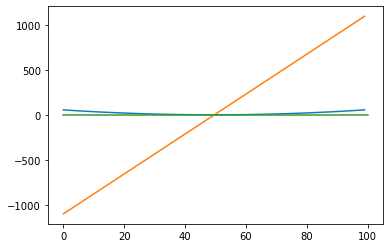

In [102]:
# verify gradients

A2 = A.copy()

i, j = 1, 1
a_list = np.linspace(A[i][j] - 0.1, A[i][j] + 0.1, 100)
results = [[], []]

for a in a_list:
    A2[i][j] = a
    results[0].append(expected_cost_lagrange(A2, P, As = As, Ps = Ps))
    results[1].append(grad_a(A2, P, i, j))

import matplotlib.pyplot as plt
plt.plot(results[0])
plt.plot(results[1])
plt.plot([0, 100],[0, 0])

der = [(j-i) * 100 / .2 for i, j in zip(results[0][:-1], results[0][1:])]
print(der[30:50])
print(results[1][30:50])


0.4832151508778412
0.4832151508778412
[[0. 0. 0.]
 [0. 0. 0.]]
[-0.49763836732275024, -0.46267095652030577, -0.4277946613329142, -0.39300924624230404, -0.3583144764207624, -0.32371011766452185, -0.28919593652254605, -0.25477170013221695, -0.22043717634812054, -0.18619213369097665, -0.1520363412566006, -0.1179695689401683, -0.08399158718086497, -0.05010216711065496, -0.016301080547620472, 0.017411900086194976, 0.0510370017003936, 0.0845744505717505, 0.11802447229314339, 0.15138729184460686]
[-0.4914819153514098, -0.4580928958036991, -0.4247887117720275, -0.3915691449008433, -0.3584339774601344, -0.3253829923417343, -0.29241597305971306, -0.25953270374686166, -0.22673296915281385, -0.19401655464270423, -0.16138324619408984, -0.12883283039651172, -0.0963650944484032, -0.06397982615525165, -0.03167681392842223, 0.0005441532185026207, 0.03268328566937165, 0.0647407932092396, 0.09671688502530754, 0.12861176970903154]


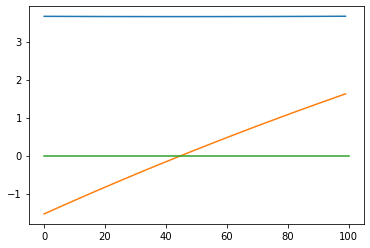

In [99]:
# verify gradients

P2 = P.copy()

i, j = 2, 2
print(P2[i][j])

print(P[i][j])
p_list = np.linspace(P[i][j] - 0.01, P[i][j] + 0.01, 100)

results = [[], []]

print(lambdas)

for p in p_list:
    P2[i][j] = p
    results[0].append(expected_cost_lagrange(A, P2, As = As, Ps = Ps))
    results[1].append(grad_p(A, P2, i, j))

import matplotlib.pyplot as plt
plt.plot(results[0])
plt.plot(results[1])
plt.plot([0, 100],[0, 0])

der = [(j-i) * 100 / .02 for i, j in zip(results[0][:-1], results[0][1:])]
print(der[30:50])
print(results[1][30:50])

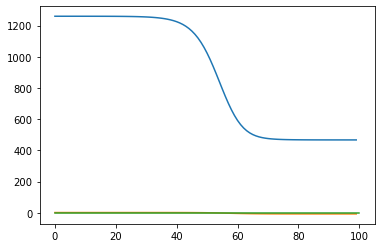

In [35]:
# verify gradients
p_list = np.linspace(-10, 10, 100)
P2 = Ps.copy()

lambdas = 0.1 * np.ones((2, n))
lambdasineq = 0.5 * np.ones((n, n))

i, j = 0, 2

results = [[], []]

for p in p_list:
    P2[i][j] = p
    results[0].append(expected_cost_lagrange(As, P2, As = As, Ps = Ps))
    results[1].append(grad_p(As, P2, i, j))

import matplotlib.pyplot as plt
plt.plot(results[0])
plt.plot(results[1])
plt.plot([0, 100],[0, 0])

To deal with the constraints that $p$ must be non-negative, we project the entries by applying the sigmoid function of each entry. Note that the range of the sigmoid is $(0, 1)$, which is also what we require for our entries $p$ (we did not explicitly constrain $p$ to be smaller than 1, but the equality constraints combined with the non-negativity constraints make sure that is the case.
To deal with the $2n$ equality constraints, we use $\textit{lagrange multipliers}$ $\lambda_{row, i}$, $i = 1, \cdots, n$ and $\lambda_{col, j}$, $j = 1, \cdots, n$. The dual function now becomes 

$$\mathcal{L}(A, P_\sigma, \mathbf{\lambda}) = C(A, P) - \sum_{i=1}^n \lambda_{row, i} \left(\sum_{j = 1}^n p_{ij} - 1\right) - \sum_{j = 1}^n \lambda_{col, j} \left(\sum_{i = 1}^n p_{ij} - 1\right),$$
where $P = \sigma(P_\sigma)$

No handles with labels found to put in legend.


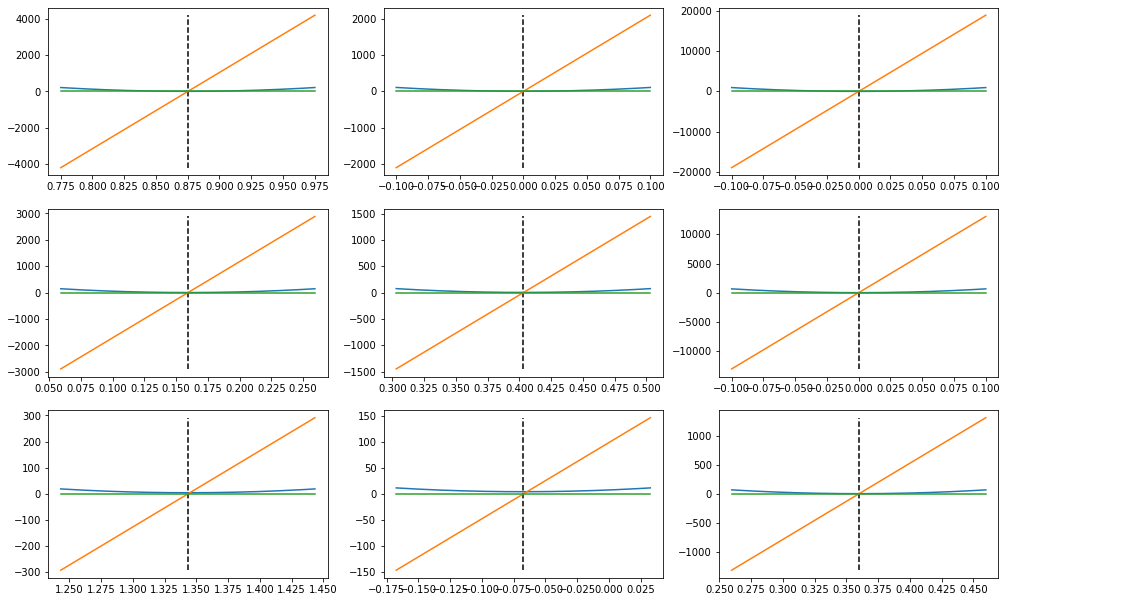

In [123]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# verify gradients


# create figure
fig = plt.figure(1)

for i in range(n):
    for j in range(n):
        A2 = A.copy()
        
        ax = fig.add_subplot(n, n, i*n +j + 1)
        a_list = np.linspace(A[i][j] - 0.1, A[i][j] + 0.1, 500)

        results = [[], []]

        for a in a_list:
            A2[i][j] = a
            results[0].append(expected_cost_lagrange(A2, P, As = As, Ps = Ps))
            results[1].append(grad_a(A2, P, i, j))

        plt.plot(a_list, results[0])
        plt.plot(a_list, results[1])
        plt.plot([a_list[0], a_list[-1]],[0, 0])
        plt.vlines(A[i][j], np.min(results), np.max(results), linestyle = '--')

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

No handles with labels found to put in legend.


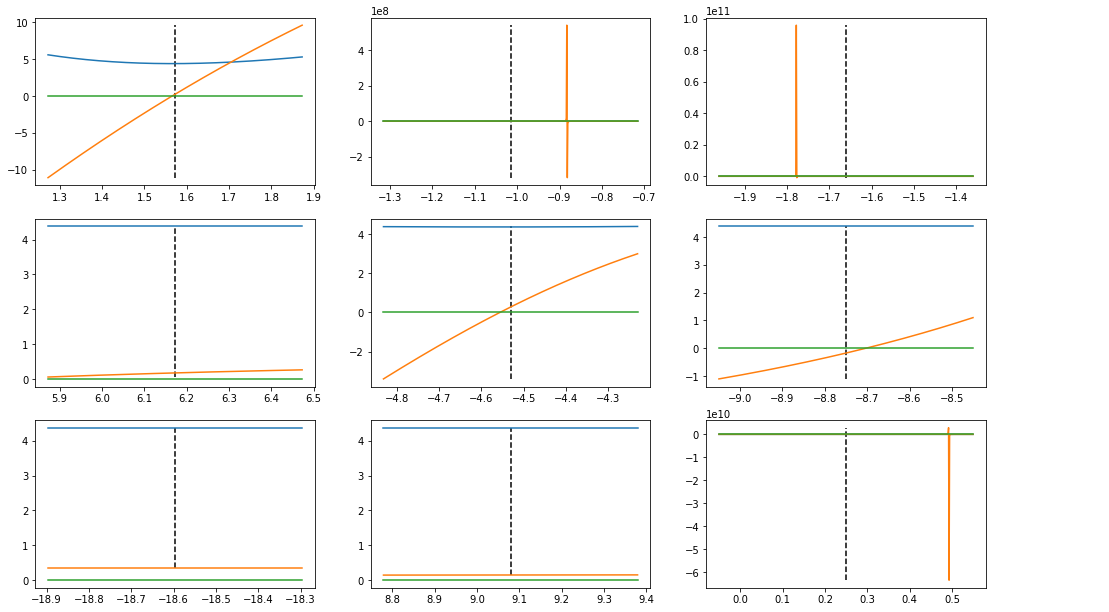

In [127]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# verify gradients


# create figure
fig = plt.figure(1)

for i in range(n):
    for j in range(n):
        P2 = P.copy()
        
        ax = fig.add_subplot(n, n, i*n +j + 1)
        p_list = np.linspace(P[i][j] - 0.3, P[i][j] + 0.3, 500)

        results = [[], []]

        for p in p_list:
            P2[i][j] = p
            results[0].append(expected_cost_lagrange(A, P2, As = As, Ps = Ps))
            results[1].append(grad_p(A, P2, i, j))

        plt.plot(p_list, results[0])
        plt.plot(p_list, results[1])
        plt.plot([p_list[0], p_list[-1]],[0, 0])
        plt.vlines(P[i][j], np.min(results), np.max(results), linestyle = '--')

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()